# Tourist Accommodations Data

**Objective**  
This part is dedicated to Data Wrangling and EDA of tourist accommodation dataset.

**Description and characteristics of dataset**  
Tourist rental property listings on major platforms.

The characteristics of this dataset are as follows:
- Estimated volume: 25,000 records every 7 days
- Historical data: Available from 2017-01

**Data description**  
[Alojamientos turísticos](https://datamarket.es/#alojamientos-turisticos-dataset)

In [2]:
# import libraries 
import os
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from dotenv import load_dotenv, find_dotenv
from mysql_table_fetcher import get_latest_table

import mysql.connector
from mysql.connector import Error

warnings.filterwarnings("ignore")

In [3]:
# font sizes
plt.rcParams['figure.titlesize'] = 18 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14             
plt.rcParams['axes.labelsize'] = 14  

plt.rcParams['xtick.labelsize'] = 12      
plt.rcParams['ytick.labelsize'] = 12       
plt.rcParams['legend.fontsize'] = 12

# display settings
#pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
 
# set palette
sns.set_palette('Paired')

sns.set_style("darkgrid")

In [4]:
# check versions of libraries
def lib_versions(libs):
    for lib in libs: print('Version', lib.__name__, '-', lib.__version__)

lib_versions([np, pd, mpl, sns])

Version numpy - 1.25.2
Version pandas - 2.0.3
Version matplotlib - 3.10.0
Version seaborn - 0.13.2


## Data Loading

In [5]:
# load environment variables
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")

# MySQL configuration
CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('HOST'),
    'database': 'Equip_F',
    'raise_on_warnings': True
}

In [6]:
# fetch latest table and its name
latest_table, df = get_latest_table(CONFIG)

Total rows in table Tourist_Accommodation07042025: 10000
MySQL connection closed


In [7]:
if df is not None:
    print(f'\nLatest table: {latest_table}')
    print('-------------')
    display(df)
else:
    print('No dataframe was fetched')


Latest table: Tourist_Accommodation07042025
-------------


,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,None,Private room,2,2,1,1.00,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",400.00,3,365,VERDADERO,7,20,40,130,78,02/01/2010,05/09/2017,970.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,75.00,spain,malaga,31/07/2018
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1,1,1.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",170.00,4,40,VERDADERO,0,0,0,162,33,10/10/2014,15/07/2018,920.00,90.00,90.00,100.00,100.00,80.00,90.00,FALSO,52.00,spain,madrid,10/01/2020
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1,2,2.00,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",990.00,2,120,VERDADERO,26,31,31,270,148,05/01/2011,22/07/2019,980.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,142.00,spain,sevilla,29/07/2019
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2,1,1.00,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",400.00,2,730,VERDADERO,9,23,49,300,292,13/03/2012,04/01/2020,940.00,100.00,90.00,100.00,100.00,100.00,90.00,VERDADERO,306.00,spain,barcelona,10/01/2020
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,None,Private room,5,1,2,5.00,"Wifi,Pool,Free parking on premises,Breakfast,P...",900.00,1,180,VERDADERO,0,19,49,312,36,08/07/2011,08/08/2018,970.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,39.00,spain,girona,19/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,47710189,Beautiful house in the centre in Santa Cristin...,Beautiful house in the center of Santa Cristin...,263841355,Santa Cristina d'Aro,None,Entire home/apt,8,2,4,6.00,"Essentials, Iron, Heating, Pool, Air condition...",1880.00,1,365,VERDADERO,0,0,0,31,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,31/01/2021
9996,47752964,Costa Brava - Palafrugell - playa y monta�a,Piso con acceso directo a piscina. Lugar muy t...,282214688,Palafrugell,None,Entire home/apt,7,2,3,4.00,"Wifi, Bathtub, Free parking on premises, BBQ g...",1130.00,1,1125,VERDADERO,29,59,89,364,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,girona,27/02/2021
9997,47792016,MODERN AND BRIGHT NEW FLAT IN THE CENTER OF PA...,Modern and new apartment in the old town of Pa...,263841355,Palam�s,None,Entire home/apt,6,1,3,4.00,"Essentials, Wifi, Air conditioning, Dishes and...",1150.00,1,365,VERDADERO,0,0,0,69,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,31/01/2021
9998,47884481,MIT House Olavide III in Madrid,The apartment is in a characteristic building ...,377605855,Trafalgar,Chamber�,Entire home/apt,4,1,1,2.00,"Patio or balcony, Bed linens, Coffee maker, Wa...",670.00,1,365,VERDADERO,16,46,76,351,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,madrid,09/02/2021


## Data Overview

In [8]:
# define function to display information about the data
def data_info(df):
   
    """Input: dataframe.
    Function displays basic information, 
    checks for duplicates and NaN. 
    """
    
    # get information about the data
    print(df.info())
    
    # number of unique values for each column
    print()
    print('\033[1mNumber of unique values')
    display(df.nunique())

    # check for NaN
    if df.isna().sum().sum() > 0:
        print()
        print('\033[1mNumber of missing values')
        display(
            pd.DataFrame({'number': df.isna().sum(), 
                          'percentage': df.isna().mean().mul(100)})
            .query('number > 0')
            .sort_values(by='number', ascending=False)
        )
    else:
        print('There are no NaNs in the data\n')
    
    # check for duplicates (without id columns)
    print()
    if df.iloc[:,1:].duplicated().sum() > 0:
        print('Data contain full duplicates\n')
    else:
        print('There are no full duplicates in the data\n')

In [9]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 10000 non-null  int64  
 1   name                         9997 non-null   object 
 2   description                  9862 non-null   object 
 3   host_id                      10000 non-null  int64  
 4   neighbourhood_name           10000 non-null  object 
 5   neighbourhood_district       6079 non-null   object 
 6   room_type                    10000 non-null  object 
 7   accommodates                 10000 non-null  int64  
 8   bathrooms                    9926 non-null   object 
 9   bedrooms                     9930 non-null   object 
 10  beds                         9955 non-null   float64
 11  amenities_list               9983 non-null   object 
 12  price                        9746 non-null   float64
 13  minimum_nights   

apartment_id                   9650
name                           9667
description                    9607
host_id                        7269
neighbourhood_name              521
neighbourhood_district           61
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             24
amenities_list                 9704
price                           419
minimum_nights                   49
maximum_nights                  147
has_availability                  1
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               319
first_review_date              2159
last_review_date               1522
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3921,39.21
review_scores_value,2724,27.24
review_scores_location,2724,27.24
review_scores_checkin,2723,27.23
review_scores_accuracy,2718,27.18
review_scores_communication,2714,27.14
review_scores_cleanliness,2712,27.12
review_scores_rating,2709,27.09
last_review_date,2605,26.05
first_review_date,2604,26.04



There are no full duplicates in the data



In [10]:
# country and cities of accomodations
df.country.unique(), df.city.unique()

(array(['spain'], dtype=object),
 array(['malaga', 'madrid', 'sevilla', 'barcelona', 'girona', 'valencia',
        'mallorca', 'menorca'], dtype=object))


---

The dataset contains 10000 rows and 35 columns.
The unique values in country and city confirm that the dataset focuses on Spain, covering six cities—'Malaga', 'Madrid', 'Sevilla', 'Barcelona', 'Girona', and 'Valencia'—as well as two islands: 'Mallorca' and 'Menorca'.

*Missing Values*
- 254 rows (2.5%) lack a `price` value.
- The `neighbourhood_district` column has 3921 missing values (~39% of the data).
- Review-related columns have between 2604 and 2724 missing values (~27% of the data).
- 550 rows are missing `has_availability` information.

*Duplicates*
- 350 duplicate values in `apartment_id`.
- 333 duplicate values in `name`.
- 393 duplicate values in `description`.
- 296 duplicate values in `amenities_list`.

*Text format issues*  
The presence of � (replacement characters) in string columns is likely due to incorrect encoding, which prevents proper display of special characters (e.g., Spanish accents: á, é, í, ó, ú, ñ).

**Conclusion**  
Before performing an exhaustive EDA, several data quality issues need to be addressed:  
*Missing Values*
- The missing `price` values should be investigated, as they directly impact the marketing business task.
- NaN values in `has_availability` can be treated as 'False', and depending on the business needs, these rows may be dropped.
- Missing values in other columns are not critical for the ongoing tasks and do not affect KPIs.

*Duplicates*  
Duplicate apartment_id, name, and description should be analyzed, they may indicate data inconsistencies or incorrect entries.

## Data Cleaning

### Data Type

- 'Date' columns have not proper datetime format, let's change it.

In [11]:
df[['first_review_date', 'last_review_date', 'insert_date']]

,first_review_date,last_review_date,insert_date
0,02/01/2010,05/09/2017,31/07/2018
1,10/10/2014,15/07/2018,10/01/2020
2,05/01/2011,22/07/2019,29/07/2019
3,13/03/2012,04/01/2020,10/01/2020
4,08/07/2011,08/08/2018,19/02/2019
...,...,...,...
9995,None,None,31/01/2021
9996,None,None,27/02/2021
9997,None,None,31/01/2021
9998,None,None,09/02/2021


In [12]:
# convert to datetime
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

df[['first_review_date', 'last_review_date', 'insert_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_review_date  7396 non-null   datetime64[ns]
 1   last_review_date   7395 non-null   datetime64[ns]
 2   insert_date        10000 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 234.5 KB


- The column `is_instant_bookable` contains values 'FALSO' and 'VERDADERO'. To simplify calculations, let's convert them to 0 and 1, respectively.

In [13]:
df['is_instant_bookable'].value_counts(dropna=False)

is_instant_bookable
VERDADERO    5806
FALSO        4194
Name: count, dtype: int64

In [14]:
# 'FALSO' -> "0", 'VERDADERO' -> "1"
df['is_instant_bookable'] = np.where(df['is_instant_bookable'] == 'VERDADERO', 1, 0)

df['is_instant_bookable'].value_counts(dropna=False)

is_instant_bookable
1    5806
0    4194
Name: count, dtype: int64

- `bathrooms`, `bedrooms`  
These variables have type *object* but should be numerical

In [15]:
df['bathrooms'].value_counts(dropna=False)

bathrooms
1       5971
2       2787
3        677
4        273
5        108
None      74
6         45
0         21
7         19
8         13
9          5
12         3
11         2
10         1
13         1
Name: count, dtype: int64

In [16]:
df['bedrooms'].value_counts(dropna=False)

bedrooms
1       4577
2       2287
3       1611
4        767
0        313
5        234
6         93
None      70
7         17
8         16
9          4
12         4
10         3
14         2
16         1
50         1
Name: count, dtype: int64

In [17]:
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 10000 non-null  int64         
 1   name                         9997 non-null   object        
 2   description                  9862 non-null   object        
 3   host_id                      10000 non-null  int64         
 4   neighbourhood_name           10000 non-null  object        
 5   neighbourhood_district       6079 non-null   object        
 6   room_type                    10000 non-null  object        
 7   accommodates                 10000 non-null  int64         
 8   bathrooms                    9926 non-null   float64       
 9   bedrooms                     9930 non-null   float64       
 10  beds                         9955 non-null   float64       
 11  amenities_list               9983 non-null

### Duplicates

Let's handle duplicates—removing them might also eliminate listings with missing prices.

In [18]:
print('Number of objects with 1 or more duplicates')
(df['apartment_id'].value_counts()>1).sum()

Number of objects with 1 or more duplicates


342

In [19]:
df['apartment_id'].value_counts().head(20)

apartment_id
10005342    3
32161182    3
10713417    3
13966456    3
14326808    3
14582385    3
24038577    3
15402794    3
22700803    2
22680591    2
27141824    2
15716926    2
15700116    2
19196593    2
2658193     2
22873587    2
15628078    2
11253321    2
2569061     2
15579708    2
Name: count, dtype: int64

In [20]:
df[df.apartment_id==15402794]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
3125,15402794,R1- Single room next to the council,Single bedroom in a symbolic building in the ...,97743716,SANT FRANCESC,CIUTAT VELLA,Private room,1,2.00,1.00,1.00,"Wifi,Elevator,Heating,Family/kid friendly,Firs...",150.00,1,1125,VERDADERO,8,25,50,297,85,2016-11-01,2019-07-01,920.00,100.00,100.00,100.00,100.00,100.00,90.00,0,254.00,spain,valencia,2019-07-31
3126,15402794,R1- Single room next to the council,Single bedroom in a symbolic building in the ...,97743716,SANT FRANCESC,CIUTAT VELLA,Private room,1,2.00,1.00,1.00,"Shampoo, Fire extinguisher, Elevator, First ai...",190.00,1,1125,VERDADERO,28,55,85,360,105,2016-11-01,2020-08-15,920.00,100.00,100.00,100.00,100.00,100.00,90.00,0,22.00,spain,valencia,2020-09-28
3127,15402794,R1- Single room next to the council,Single bedroom in a symbolic building in the ...,97743716,SANT FRANCESC,CIUTAT VELLA,Private room,1,2.00,1.00,1.00,"Wifi,Elevator,Heating,Family/kid friendly,Firs...",150.00,1,1125,VERDADERO,26,50,69,313,103,2016-11-01,2020-03-09,920.00,100.00,100.00,100.00,100.00,100.00,90.00,0,247.00,spain,valencia,2020-03-26


Some objects with the same `apartment_id` have 1 or even 2 duplicates recorded on different `insert_date` values. Let's check whether they also share the same name and location, as it's possible for different properties to have the same name but be in different places.

In [21]:
res = (df[df['apartment_id'].duplicated(keep=False)]
       .groupby('apartment_id')[['name', 'description', 'room_type', 'host_id', 'city', 'insert_date']]
       .nunique())
res

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
144471,1,1,1,1,1,2
157327,1,1,1,1,1,2
343864,1,1,1,1,1,2
503253,1,1,1,1,1,2
886569,1,2,1,1,1,2
...,...,...,...,...,...,...
42753906,1,1,1,1,1,2
42887774,1,2,1,1,1,2
42922000,1,2,1,1,1,2


In [22]:
res[res.insert_date<2]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,


`apartment_id` duplicates always have different `insert_date` → We can keep the most recent entry.

In [23]:
res[res.city>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,


`apartment_id` duplicates always belong to the same city → This supports the idea that they are actual duplicates rather than different properties.

In [24]:
res[res.room_type>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
14288527,1,2,2,1,1,2
18682379,2,2,2,1,1,2
24342447,1,1,2,1,1,2
35314072,1,1,2,1,1,2
38261282,2,1,2,1,1,2


In [25]:
df[df.apartment_id.isin(res[res.room_type>1].index)]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
2861,14288527,"Great penthouse with terrace, overlooking the sea",-The accommodation meets the Sanitary Cleaning...,34433429,Centro,None,Entire home/apt,2,1.00,1.00,1.00,"Free street parking, Garden or backyard, Iron,...",670.00,2,31,VERDADERO,19,49,79,160,237,2016-08-10,2020-10-12,970.00,100.00,100.00,100.00,100.00,100.00,100.00,1,443.00,spain,malaga,2020-12-30
2862,14288527,"Great penthouse with terrace, overlooking the sea","Great penthouse with terrace, overlooking the ...",34433429,Este,None,Private room,2,1.00,1.00,1.00,"TV,Internet,Wireless Internet,Pool,Free parkin...",440.00,2,15,VERDADERO,14,18,40,41,102,2016-08-10,2017-11-21,970.00,100.00,100.00,100.00,100.00,90.00,100.00,1,647.00,spain,malaga,2017-11-25
4238,18682379,"Lush, sunny & quiet 2 bedroom apartment",Search no more! Welcome to your spacious 2 bed...,27775148,la Dreta de l'Eixample,Eixample,Entire home/apt,4,1.00,2.00,2.00,"Wifi,Kitchen,Breakfast,Elevator,Family/kid fri...",2750.00,4,60,VERDADERO,0,8,8,14,8,2017-07-18,2019-01-01,1000.00,100.00,100.00,100.00,100.00,100.00,90.00,0,44.00,spain,barcelona,2019-01-14
4239,18682379,"Lush, sunny & quiet 2ble room in Barcelona center",Search no more! Welcome to your spacious doubl...,27775148,la Dreta de l'Eixample,Eixample,Private room,2,1.00,1.00,1.00,"Wireless Internet,Kitchen,Breakfast,Elevator,F...",650.00,2,20,VERDADERO,0,0,13,288,4,2017-07-18,2017-08-18,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,0,146.00,spain,barcelona,2017-10-07
6262,24342447,Suite Apt 4 pax en Sants,Apartamento con capacidad para 4 personas con ...,3346610,Sants,Sants-Montju�c,Hotel room,4,NaN,1.00,4.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets...",2000.00,1,1125,VERDADERO,0,16,46,160,8,2018-08-04,2019-10-23,900.00,90.00,90.00,100.00,100.00,100.00,90.00,1,34.00,spain,barcelona,2020-07-17
6263,24342447,Suite Apt 4 pax en Sants,Apartamento con capacidad para 4 personas con ...,3346610,Sants,Sants-Montju�c,Entire home/apt,4,1.00,1.00,2.00,"Internet,Wifi,Air conditioning,Free parking on...",1650.00,1,1125,VERDADERO,28,58,88,215,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,barcelona,2018-07-10
8686,35314072,Apartment in 4 * Majorca residential complex,The apartment has all the comforts and is loca...,72847499,Llucmajor,None,Hotel room,4,1.00,1.00,1.00,"TV,Air conditioning,Pool,Kitchen,Free parking ...",1400.00,7,7,VERDADERO,0,0,0,118,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,mallorca,2019-09-28
8687,35314072,Apartment in 4 * Majorca residential complex,The apartment has all the comforts and is loca...,72847499,Llucmajor,None,Entire home/apt,4,1.00,1.00,1.00,"TV,Air conditioning,Pool,Kitchen,Free parking ...",2000.00,7,7,VERDADERO,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,mallorca,2019-11-28
9146,38261282,Baul� Mar_End of summer holiday.,Los Apartamentos Baul� Mar est�n situados en u...,65949984,Santa Margalida,None,Hotel room,4,1.00,1.00,4.00,"TV,Cable TV,Wifi,Pool,Kitchen,Free street park...",550.00,3,1125,VERDADERO,0,0,0,0,1,2019-10-08,2019-10-08,1000.00,80.00,60.00,100.00,100.00,100.00,100.00,1,10.00,spain,mallorca,2019-10-28
9147,38261282,Baul� Mar_Summer holiday 2020.,Los Apartamentos Baul� Mar est�n situados en u...,65949984,Santa Margalida,None,Entire home/apt,4,1.00,1.00,4.00,"Wifi, Coffee maker, Dishes and silverware, Fir...",750.00,1,1125,VERDADERO,30,50,80,80,3,2019-10-08,2019-11-09,1000.00,90.00,80.00,100.00,100.00,90.00,100.00,1,26.00,spain,mallorca,2020-09-19


In [26]:
res[res.host_id>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
19196593,2,2,1,2,1,2


In [27]:
df.query('apartment_id==19196593')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4492,19196593,"Centro 4 con garaje gratis, 1 dormitorio",Apartamento de 1 dormitorio con garaje incluid...,18077486,Cruz De Humilladero,None,Entire home/apt,4,1.00,1.00,3.00,"Free street parking, Iron, Washer, Hot water, ...",500.00,2,1125,VERDADERO,0,0,0,213,42,2017-06-27,2020-09-05,930.00,100.00,90.00,100.00,100.00,90.00,90.00,1,98.00,spain,malaga,2020-12-30
4493,19196593,"CENTRO 4 CON GARAJE GRATIS, APARTAM. VFT/MA/13723","Supermercado Mercadona a 1 minuto, tiendas y b...",134286611,Bailen-Miraflores,None,Entire home/apt,4,1.00,1.00,3.00,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",500.00,2,1125,VERDADERO,0,0,0,181,29,2017-06-27,2018-09-30,940.00,100.00,90.00,100.00,100.00,90.00,90.00,1,16.00,spain,malaga,2018-12-22


In [28]:
df.query('apartment_id==19196593')['name']

4492             Centro 4 con garaje gratis, 1 dormitorio
4493    CENTRO 4 CON GARAJE GRATIS, APARTAM. VFT/MA/13723
Name: name, dtype: object

In [29]:
res[res.name>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
1624014,2,2,1,1,1,2
3163230,2,2,1,1,1,2
3634997,2,2,1,1,1,2
3770072,2,2,1,1,1,2
6584564,2,2,1,1,1,2
7029540,2,1,1,1,1,2
9619438,2,2,1,1,1,2
10806296,2,1,1,1,1,2
12514998,2,2,1,1,1,2


In [30]:
ap_id_dupl_name = res[(res.name>1) & (res.description>1) & (res.host_id<2)].index
df[df.apartment_id.isin(ap_id_dupl_name)]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
470,1624014,Beautiful apartment to Enjoy the real Barcelona,Recently refurbished modern and spacious 3 bed...,1260560,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,3.00,5.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",1600.00,3,90,VERDADERO,16,46,76,334,141,2014-04-14,2020-01-06,910.00,90.00,90.00,100.00,100.00,90.00,90.00,1,198.00,spain,barcelona,2020-02-16
471,1624014,Brand-New Low Priced Large Apt 6p,Recently refurbished modern and spacious 3 bed...,1260560,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,3.00,5.00,"TV,Cable TV,Internet,Wireless Internet,Air con...",1870.00,3,1125,None,0,17,47,322,51,2014-04-14,2016-12-04,890.00,90.00,90.00,90.00,90.00,90.00,90.00,1,153.00,spain,barcelona,2017-01-04
758,3163230,Apartment in Sagrada Familia for 4 - WIFI,Bel appartement � 100 m de La Sagrada Familia....,8811801,la Sagrada Fam�lia,Eixample,Entire home/apt,4,1.00,2.00,3.00,"Dedicated workspace, Oven, Cooking basics, Dis...",600.00,15,330,VERDADERO,1,31,61,336,39,2014-06-16,2019-10-10,860.00,90.00,90.00,90.00,100.00,90.00,90.00,0,49.00,spain,barcelona,2021-01-12
759,3163230,PISO PARA 5 EN SAGRADA FAMILIA,Piso muy lindo y comodo que puede acoger hasta...,8811801,la Sagrada Fam�lia,Eixample,Entire home/apt,5,1.00,2.00,3.00,"TV,Wireless Internet,Kitchen,Elevator in build...",900.00,7,365,None,0,0,0,196,38,2014-06-16,2017-05-18,860.00,90.00,90.00,90.00,100.00,90.00,90.00,1,105.00,spain,barcelona,2017-06-05
855,3634997,"Elegant Apt in Eixample, near Paseo de Gracia",Elegant and Original 160 sqm apartment - 12 pe...,2439400,la Dreta de l'Eixample,Eixample,Entire home/apt,12,2.00,6.00,9.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Paid...",3000.00,2,300,VERDADERO,11,19,19,147,34,2014-08-05,2018-03-02,830.00,80.00,90.00,100.00,90.00,90.00,80.00,1,74.00,spain,barcelona,2018-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393,34198308,TRAMUNTANA (INCA) - Villa for 6 people in Inca.,Welcome to this magnificient country house for...,80839530,Inca,None,Entire home/apt,6,2.00,3.00,6.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",1180.00,7,1125,VERDADERO,0,9,35,126,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,mallorca,2019-07-25
8671,35229630,Holiday villa Can Vidal with swimming pool in ...,Can Vidal is a holiday home with swimming pool...,81580920,Mancor de la Vall,None,Entire home/apt,8,3.00,4.00,6.00,"TV,Cable TV,Internet,Wifi,Pool,Kitchen,Free pa...",2030.00,1,1125,VERDADERO,0,0,0,63,1,2019-08-18,2019-08-18,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,42.00,spain,mallorca,2019-10-28
8672,35229630,"Can Vidal, Villa en Mancor de la Vall, Mallorca",Holiday villa Can Vidal with swimming pool in ...,81580920,Mancor de la Vall,None,Entire home/apt,8,3.00,4.00,4.00,"Hair dryer, Dishes and silverware, Heating, Hi...",2460.00,1,1125,VERDADERO,0,0,0,63,1,2019-08-18,2019-08-18,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,6.00,spain,mallorca,2020-12-19
8868,36374977,Parque Mira Flores - Sevilla Capital,"Habitaci�n con vista para la piscina, ba�o pri...",273116926,San Diego,Macarena - Norte,Private room,1,1.00,1.00,1.00,"Refrigerator, Host greets you, Essentials, Cof...",260.00,1,30,VERDADERO,30,60,90,365,25,2019-07-15,2020-11-02,910.00,100.00,100.00,100.00,100.00,90.00,90.00,1,148.00,spain,sevilla,2020-11-30


The names vary, but other characteristics remain similar. Sometimes, hosts adjust details, such as reducing the number of guests or changing the listing from a private room to an entire apartment.

Given these factors, we can decide to **retain only the most recent entry for each `apartment_id`** to ensure we have the latest and most relevant data.

#### Remove duplicates

In [31]:
# data with unique apartment_id
df_clean = (df.sort_values(by=['apartment_id', 'insert_date'], 
                           ascending=[True, False])
              .drop_duplicates(subset=['apartment_id'], keep='first')
           )

In [32]:
data_info(df_clean)

<class 'pandas.core.frame.DataFrame'>
Index: 9650 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9516 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9578 non-null   float64       
 9   bedrooms                     9580 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9634 non-null   obj

apartment_id                   9650
name                           9614
description                    9459
host_id                        7268
neighbourhood_name              521
neighbourhood_district           61
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             24
amenities_list                 9492
price                           418
minimum_nights                   49
maximum_nights                  147
has_availability                  1
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              2159
last_review_date               1513
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3790,39.27
review_scores_value,2640,27.36
review_scores_location,2640,27.36
review_scores_checkin,2639,27.35
review_scores_accuracy,2634,27.30
review_scores_communication,2630,27.25
review_scores_cleanliness,2628,27.23
review_scores_rating,2625,27.20
last_review_date,2523,26.15
first_review_date,2522,26.13



There are no full duplicates in the data



In [33]:
print('Number of objects with 1 or more duplicated description')
(df_clean['description'].value_counts()>1).sum()

Number of objects with 1 or more duplicated description


42

In [34]:
print('Number of objects with 1 or more duplicated name')
(df_clean['name'].value_counts()>1).sum()

Number of objects with 1 or more duplicated name


30

---

We still have 241 objects without a price and more than 30 objects with non-unique names and descriptions. While it is possible for multiple appartments to share the same description—such as when a host owns similar apartments in the same building—these cases should be analyzed further to ensure data accuracy and make informed decisions.

In [35]:
df_clean[df_clean['description'].duplicated(keep=False)].sort_values(by='description').head(20)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
5120,20950596,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,29,59,89,364,3,2017-10-07,2018-01-19,800.00,80.00,90.00,90.00,100.00,70.00,90.00,1,32.00,spain,barcelona,2018-07-10
5119,20950570,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,17,47,77,352,22,2017-10-05,2019-03-05,890.00,90.00,90.00,100.00,100.00,80.00,90.00,1,119.00,spain,barcelona,2019-04-10
9929,45049433,Room for rent in shared apartment,<b>License number</b><br />Exempt,269738253,la Sagrera,Sant Andreu,Private room,1,1.00,1.00,1.00,"Elevator, Essentials, Hangers, Dedicated works...",250.00,2,365,VERDADERO,30,60,90,365,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,barcelona,2021-02-09
7071,27545229,Habitaci�n en paseo maragall,<b>License number</b><br />Exempt,145884948,Horta,Horta-Guinard�,Private room,2,1.00,1.00,1.00,"Elevator, Essentials, Hair dryer, Hangers, Ext...",400.00,2,1125,VERDADERO,0,0,0,0,4,2018-08-16,2018-09-07,950.00,100.00,100.00,100.00,100.00,90.00,100.00,1,13.00,spain,barcelona,2021-02-09
6812,26424500,BCN Greatest Location Little Cozy Room,<b>License number</b><br />Exempt,160635054,la Dreta de l'Eixample,Eixample,Private room,1,1.00,1.00,1.00,"Wifi, Kitchen, Heating, Dedicated workspace, E...",320.00,3,1125,VERDADERO,0,0,0,0,2,2018-07-02,2018-09-14,600.00,40.00,20.00,60.00,100.00,100.00,40.00,1,6.00,spain,barcelona,2021-01-12
7925,32082385,Cozy room on Barcelona Centre,<b>License number</b><br />Exempt,227992730,la Vila de Gr�cia,Gr�cia,Private room,1,1.00,1.00,1.00,"Elevator, Hot water, Free parking on premises,...",500.00,1,1125,VERDADERO,30,60,90,365,1,2019-06-27,2019-06-27,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,6.00,spain,barcelona,2020-10-12
8458,34532256,Conoce Barcelona con una estancia acogedora,<b>License number</b><br />Exempt,222186315,el Guinard�,Horta-Guinard�,Private room,1,1.00,1.00,1.00,"Refrigerator, Microwave, Stove, First aid kit,...",350.00,1,1125,VERDADERO,0,0,0,0,2,2019-05-20,2019-05-30,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,12.00,spain,barcelona,2020-09-12
8885,36501879,"Doble room in my shared flat, near de the sea.",<b>License number</b><br />Exempt,210140436,el Poblenou,Sant Mart�,Private room,2,2.00,1.00,1.00,"Kitchen, Essentials, Hair dryer, Washer, Eleva...",340.00,1,10,VERDADERO,30,60,90,180,17,2019-08-09,2020-01-22,810.00,90.00,80.00,80.00,80.00,100.00,90.00,1,118.00,spain,barcelona,2020-10-12
9010,37271148,Confortable habitaci�n en zona exclusiva,<b>License number</b><br />Exempt,280582099,la Dreta de l'Eixample,Eixample,Private room,3,1.00,NaN,1.00,"Elevator, Essentials, Breakfast, Hot water, Ki...",700.00,1,1125,VERDADERO,29,59,89,179,1,2019-08-01,2019-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,8.00,spain,barcelona,2020-08-24
9458,40716257,Lovely place at Gracia,<b>License number</b><br />Exempt,94155196,la Salut,Gr�cia,Private room,2,1.00,NaN,1.00,"Essentials, Long term stays allowed, Hot water...",250.00,2,1125,VERDADERO,30,60,90,365,1,2020-02-01,2020-02-01,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,0,8.00,spain,barcelona,2021-02-09


In [36]:
df_clean['name'].value_counts().head()

name
Amazing villa with swimming-pool                                 3
Beautiful two bedroom appartment with comunitary swiming-pool    3
Apartaments Ponent 1 habitacion                                  3
Alquiler de habitaci�n                                           2
Beautiful room only girls                                        2
Name: count, dtype: int64

In [37]:
# duplicates of name
df_clean[df_clean['name'].duplicated(keep=False)].sort_values(by='name')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
5120,20950596,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,29,59,89,364,3,2017-10-07,2018-01-19,800.00,80.00,90.00,90.00,100.00,70.00,90.00,1,32.00,spain,barcelona,2018-07-10
5119,20950570,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,17,47,77,352,22,2017-10-05,2019-03-05,890.00,90.00,90.00,100.00,100.00,80.00,90.00,1,119.00,spain,barcelona,2019-04-10
9221,38868954,Alquiler de habitaci�n,None,296993538,Centro,None,Private room,2,1.00,1.00,1.00,"TV,Wifi,Kitchen,Smoking allowed,Pets allowed,E...",500.00,1,7,VERDADERO,30,60,90,365,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,malaga,2019-11-30
7249,28512671,Alquiler de habitaci�n,"Es un D�plex de dos habitaciones, una habitaci...",5952599,Ciutadella de Menorca,None,Private room,1,1.00,1.00,1.00,"Wifi,Air conditioning,Pool,Kitchen,Elevator,Wa...",200.00,2,7,VERDADERO,7,7,7,7,2,2018-10-09,2018-10-18,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,20.00,spain,menorca,2018-10-25
8034,32590816,Alquilo habitacion,Hola a tod@s!!! Somos un matrimonio de origen ...,181033010,Puerta del Angel,Latina,Private room,1,1.00,1.00,1.00,"Wifi,Kitchen,Pets allowed,Heating,Washer,Dryer...",3000.00,1,120,VERDADERO,29,59,89,364,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,madrid,2019-06-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5783,23068595,VILLA MAR,Luxuri�ses-Ferienhaus f�r 12 Personen mit 3 Wo...,43337979,Santa Margalida,None,Entire home/apt,12,8.00,6.00,12.00,"TV,Wifi,Air conditioning,Kitchen,Family/kid fr...",NaN,7,1125,VERDADERO,8,19,49,91,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,mallorca,2018-08-21
7902,31999442,VILLA MAR,Villa Mar is a fantastic property; Constructed...,24926928,Alc�dia,None,Entire home/apt,8,2.00,4.00,6.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",1400.00,5,1125,VERDADERO,21,23,39,241,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,mallorca,2019-06-27
1507,7164589,None,"exterior, bright, and charming room, in the ce...",37525983,Palacio,Centro,Private room,1,2.00,1.00,1.00,],300.00,1,1125,VERDADERO,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,madrid,2020-10-17
1581,7576999,None,"This fantastic private bedroom, located in a p...",14415017,el Putxet i el Farr�,Sarri�-Sant Gervasi,Private room,2,2.00,1.00,1.00,"Indoor fireplace, TV, Heating, Kitchen, Wifi, ...",300.00,1,1125,VERDADERO,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,barcelona,2020-09-12


Let's decide to keep objects with the same `name` and `description` - it is possible for multiple appartments to share the same description—such as when a host owns similar apartments in the same building.

### Missing Values

#### has_availability
This column has more than 500 NaN values, let's see how they are distributed in our data.

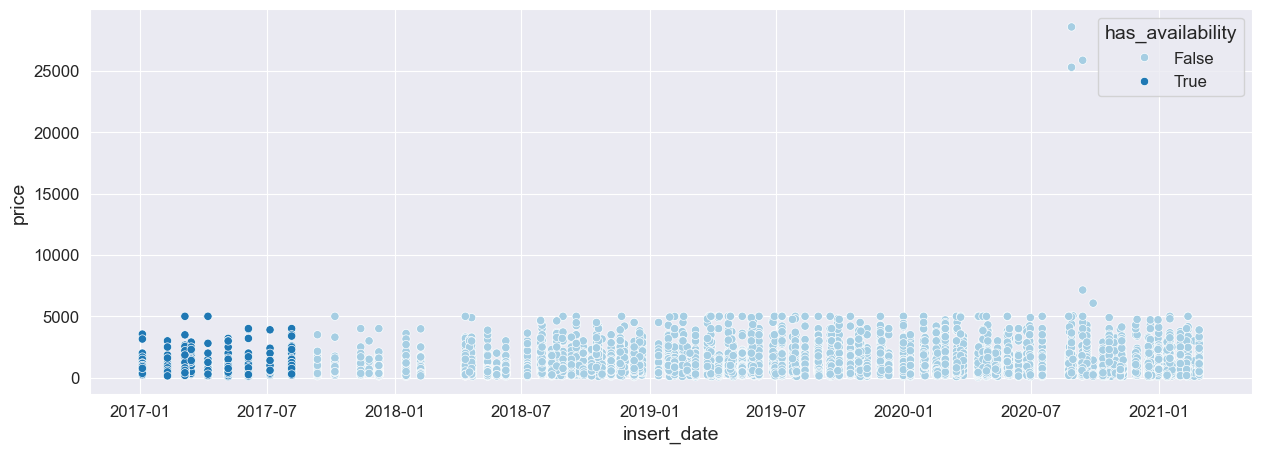

In [38]:
# distribution of has_availability values over time
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_clean, x='insert_date', y='price', hue=df_clean['has_availability'].isna())
plt.show()

NaN values in `has_availability` may be due to this variable being introduced after August 2017. To simplify calculations, we can treat NaN values as 'False'.

In [39]:
# NaN -> "0", 'VERDADERO' -> "1"
df_clean['has_availability'] = np.where(df_clean['has_availability'] == 'VERDADERO', 1, 0)

df_clean['has_availability'].value_counts(dropna=False)

has_availability
1    9116
0     534
Name: count, dtype: int64

#### price
We have 241 objects without a `price`, we can **design an imputation strategy**, as price is a key value for our analysis and decision-making

First, lets investigate when we had objects with missing prices: let's see if the missing prices are more characteristic of specific days. Let's use `availability_30` to visualize this.

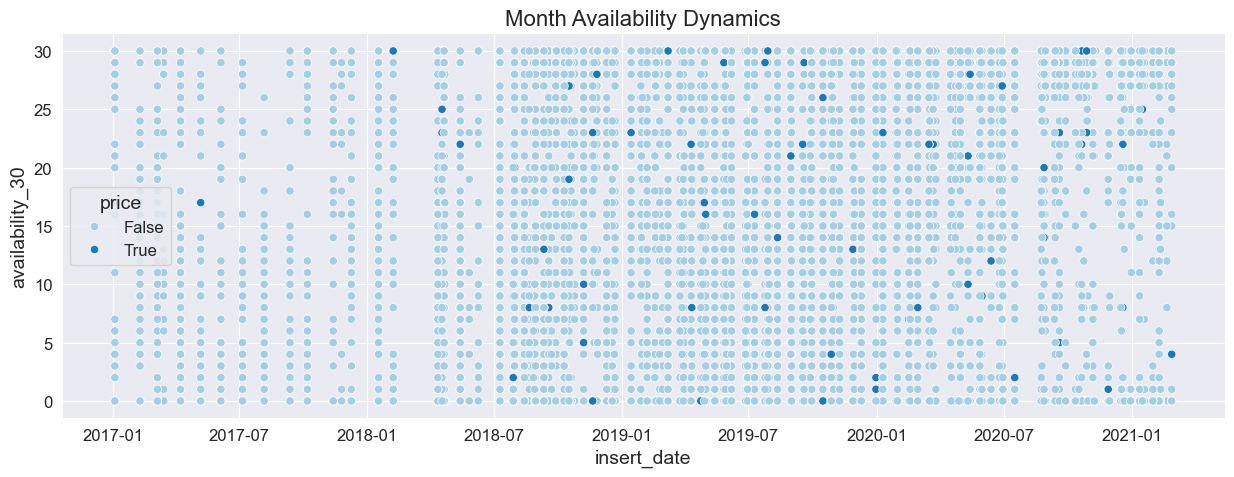

In [40]:
# availability_30 dynamics
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_clean, x='insert_date', y='availability_30', 
                hue=df_clean['price'].isna())
plt.title('Month Availability Dynamics')
plt.show()

In [41]:
print('Number of missing prices per day')
df_clean.query('price.isna()').insert_date.value_counts()

Number of missing prices per day


insert_date
2020-06-13    9
2020-02-29    9
2019-08-12    7
2019-12-31    7
2019-10-16    6
             ..
2018-07-10    1
2021-01-19    1
2018-08-21    1
2019-02-17    1
2020-03-16    1
Name: count, Length: 99, dtype: int64

Although some `insert_dates` have more than one missing price, there are no specific days with a large number of missing prices. Therefore, we can almost rule out a technical error.

Let's see if missing prices are caracteristic for specific values of different columns.

In [42]:
cols = ['host_id', 'city', 'neighbourhood_district', 'neighbourhood_name',
        'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
        'minimum_nights', 'has_availability', 'availability_30',
        'availability_60', 'availability_90', 'availability_365',
        'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'is_instant_bookable'
        ]

for col in cols:
    print()
    print(df_clean.query('price.isna()')[col].value_counts())


host_id
4459553      9
231620389    8
206349691    6
4645996      3
43337979     3
            ..
26698362     1
115399167    1
40506914     1
159698484    1
369955660    1
Name: count, Length: 193, dtype: int64

city
mallorca     96
madrid       50
barcelona    46
girona       26
menorca      11
sevilla       8
valencia      3
malaga        1
Name: count, dtype: int64

neighbourhood_district
Eixample                 21
Centro                   17
Sant Mart�                8
Salamanca                 6
Casco Antiguo             6
Gr�cia                    6
San Blas - Canillejas     5
Ciutat Vella              4
Usera                     4
Sants-Montju�c            3
Sarri�-Sant Gervasi       3
Fuencarral - El Pardo     3
Triana                    2
Ciudad Lineal             2
Hortaleza                 2
Retiro                    2
Chamber�                  2
Latina                    2
CIUTAT VELLA              2
RASCANYA                  1
Arganzuela                1
Villa de Vallec

We can see that the prices are mostly missing for large and probably expensive whole apartments/houses, in half of the cases - in Mallorca. As a rule, they have high ratings, but in a large number of cases there are no reviews. Also, there are hosts with several objects without price, let's check them.

In [43]:
# host with 7 missing prices
df_clean.query('host_id==4459553')['city'].value_counts()

city
barcelona    32
Name: count, dtype: int64

In [44]:
df_clean.query('host_id==4459553')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
743,3107710,1563 - AB Pla�a Espanya 2-1 - Classy 3-Bedroom...,This modish three bedroom holiday apartment in...,4459553,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,3.00,6.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",NaN,2,330,1,9,34,64,339,11,2016-06-20,2018-08-20,800.00,80.00,90.00,80.00,80.00,90.00,80.00,1,38.00,spain,barcelona,2018-11-07
2759,13988785,1993 - AB Pla�a Espanya XI - Stylish 3-Bedroom...,This lovely apartment is situated in the centr...,4459553,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,1.00,3.00,6.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",3500.00,3,330,1,0,0,0,69,18,2018-01-01,2019-08-17,790.00,80.00,90.00,80.00,90.00,90.00,80.00,1,8.00,spain,barcelona,2019-11-09
3033,15066661,1908 - AB Vila i Vil� Apartment 4-1 - Lovely A...,"This is a comfortable apartment in Barcelona, ...",4459553,el Poble Sec,Sants-Montju�c,Entire home/apt,6,1.00,3.00,6.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",4000.00,2,330,1,13,14,40,315,34,2017-03-25,2019-11-11,800.00,80.00,80.00,80.00,80.00,90.00,80.00,1,103.00,spain,barcelona,2019-12-10
3096,15262802,1554 - AB Passeig de Gr�cia Pelai - Modern Cit...,"This spacious apartment in Barcelona, recently...",4459553,el Raval,Ciutat Vella,Entire home/apt,7,1.00,2.00,5.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",NaN,3,330,1,10,23,50,306,29,2016-12-29,2018-11-19,860.00,90.00,90.00,80.00,90.00,100.00,90.00,1,122.00,spain,barcelona,2018-12-10
3196,15712249,327 - AB Central Villarroel - Trendy City Cent...,This charming two-bedroom apartment in Barcelo...,4459553,Sant Antoni,Eixample,Entire home/apt,5,1.00,2.00,3.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets...",3500.00,3,330,1,6,17,29,304,15,2018-05-10,2019-06-17,830.00,80.00,80.00,90.00,100.00,90.00,90.00,1,105.00,spain,barcelona,2019-07-10
3847,17726001,2427 - AB Plaza Catalunya Luxury Apartment 3-4,"This luxurious, two bedroom apartment is perfe...",4459553,la Dreta de l'Eixample,Eixample,Entire home/apt,6,2.00,2.00,2.00,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,3,1125,0,2,16,45,135,4,2017-03-27,2017-07-22,1000.00,100.00,100.00,100.00,100.00,100.00,90.00,1,9.00,spain,barcelona,2017-08-06
3849,17726179,2428 - AB Pla�a Catalunya 1-2 - Modern Apartme...,"This sleek, modern four-bedroom apartment is t...",4459553,la Dreta de l'Eixample,Eixample,Entire home/apt,10,2.00,3.00,7.00,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",NaN,3,330,1,5,24,51,317,12,2017-07-25,2018-06-30,820.00,90.00,90.00,90.00,90.00,100.00,80.00,1,76.00,spain,barcelona,2018-11-07
3869,17755675,2292 - AB Arag� Apartment 1-C - Modern Apartme...,"This chic and stylish apartment, in a recently...",4459553,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,2.00,5.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",5000.00,2,330,1,3,33,61,330,15,2017-07-25,2019-03-11,870.00,90.00,90.00,90.00,90.00,90.00,80.00,1,72.00,spain,barcelona,2019-04-10
3874,17757695,2294 - AB Arag� Apartment 2-C - Central Apartm...,"This superb apartment, in a recently renovated...",4459553,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,2.00,5.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",5000.00,2,330,1,27,57,87,362,18,2017-09-09,2019-03-25,810.00,90.00,90.00,90.00,90.00,90.00,80.00,1,93.00,spain,barcelona,2019-04-10
3914,17835432,2296 - AB Arag� Apartment 3-C - Stylish Apartm...,You�ll find this exceptionally-located apartme...,44595

We can see that some objects do not have prices, while similar ones do. We can assume that these are similar objects and we could later use their prices to fill in NaNs.

#### Handling Missing Prices

We can find similar prices based on the characteristics of each accommodation and host_id. But at the moment let's decide to keep missing values.

#### Reviews

In [47]:
df_no_reviews = df_clean[df_clean['number_of_reviews'] == 0]

# Count NaN values in the relevant columns for rows where number_of_reviews == 0
nan_count = df_no_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                           'review_scores_accuracy', 'review_scores_cleanliness', 
                           'review_scores_checkin', 'review_scores_communication', 
                           'review_scores_location', 'review_scores_value']].isna().sum()

print("NaN Count in each column for rows with number_of_reviews == 0:")
print(nan_count)

NaN Count in each column for rows with number_of_reviews == 0:
first_review_date              2519
last_review_date               2519
review_scores_rating           2519
review_scores_accuracy         2519
review_scores_cleanliness      2519
review_scores_checkin          2519
review_scores_communication    2519
review_scores_location         2519
review_scores_value            2519
dtype: int64


In [48]:
# Check unique values for each column
unique_values = df_no_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                               'review_scores_accuracy', 'review_scores_cleanliness', 
                               'review_scores_checkin', 'review_scores_communication', 
                               'review_scores_location', 'review_scores_value']].nunique()

print("\nUnique Values count for each column for rows with number_of_reviews == 0:")
print(unique_values)


Unique Values count for each column for rows with number_of_reviews == 0:
first_review_date              0
last_review_date               0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64


#### Indicator for Presence of Reviews in Accommodations

For the rows where `'number_of_reviews' == 0`, all the review-related data is missing (i.e., `NaN`). This suggests that the accommodation has no reviews.

Thus, the column `'number_of_reviews'` can be used as an indicator for the **presence or absence of reviews** for a given accommodation. If `'number_of_reviews' == 0`, this indicates that there are no reviews for that accommodation, and we can consider the review-related fields as absent.

We can use this insight to handle missing values or filter data based on the presence or absence of reviews.


In [49]:
# Filter rows where 'number_of_reviews' is not equal to 0
df_yes_reviews = df_clean[df_clean['number_of_reviews'] != 0]

# Count NaN values in the relevant columns for rows where 'number_of_reviews' != 0
nan_count = df_yes_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                            'review_scores_accuracy', 'review_scores_cleanliness', 
                            'review_scores_checkin', 'review_scores_communication', 
                            'review_scores_location', 'review_scores_value']].isna().sum()

print("NaN Count in each column for rows with number_of_reviews != 0:")
print(nan_count)

NaN Count in each column for rows with number_of_reviews != 0:
first_review_date                3
last_review_date                 4
review_scores_rating           106
review_scores_accuracy         115
review_scores_cleanliness      109
review_scores_checkin          120
review_scores_communication    111
review_scores_location         121
review_scores_value            121
dtype: int64


In [50]:
# Filter rows where any of the selected columns have NaN values
df_with_nan = df_yes_reviews[df_yes_reviews[[
    'first_review_date', 'last_review_date', 'review_scores_rating', 
    'review_scores_accuracy', 'review_scores_cleanliness', 
    'review_scores_checkin', 'review_scores_communication', 
    'review_scores_location', 'review_scores_value']].isna().any(axis=1)]

# Print the rows with NaN values
df_with_nan

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
596,2368293,MAISON AU CALME AVEC PISCINE,Photos et description de la location a EMPURIA...,12100602,Castell� d'Emp�ries,None,Entire home/apt,6,1.00,2.00,3.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",1270.00,2,30,1,0,0,0,0,2,2017-04-12,2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,9.00,spain,girona,2019-02-19
734,3073348,"APARTAMENTOS AQUARIUM. 25 M2 TERRAZA, BARBACOA","Apartamento con 1 habitaci�n doble, comedor co...",14040896,Roses,None,Entire home/apt,4,1.00,1.00,4.00,"TV,Kitchen,Smoking allowed,Pets allowed,Free s...",520.00,3,30,1,26,48,78,325,1,2014-07-15,2014-07-15,200.00,NaN,100.00,20.00,80.00,NaN,40.00,0,2.00,spain,girona,2018-11-26
1045,4847335,"Chalet independiente, muy tranquilo","Ideal acceso a playas, naturaleza en zona, sen...",24830684,Santany�,None,Entire home/apt,8,3.00,4.00,6.00,"TV,Pool,Kitchen,Smoking allowed,Pets allowed,H...",1900.00,3,1125,1,0,0,0,0,2,2015-04-28,2015-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.00,spain,mallorca,2018-07-29
1172,5486531,"Villa: TEOLUNA, Begur, Costa Brava",Beautiful house located in the urbanization re...,26281633,Begur,None,Entire home/apt,12,4.00,5.00,6.00,"TV,Pool,Kitchen,Free parking on premises,Heati...",2530.00,7,1125,1,29,29,29,29,1,2017-07-22,2017-07-22,800.00,NaN,60.00,NaN,NaN,NaN,NaN,1,7.00,spain,girona,2018-09-28
1179,5542982,Estudio Avenida de America Madrid,"Estudio con capacidad 3 personas ,2 camas dobl...",8177214,Guindalera,Salamanca,Entire home/apt,2,1.00,0.00,2.00,"TV,Internet,Wifi,Wheelchair accessible,Kitchen...",350.00,15,350,1,24,48,78,353,1,2019-01-21,2019-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,37.00,spain,madrid,2019-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,40169417,SWEET HOME,Operamos una casa de familia principalmente po...,310147857,RUSSAFA,L'EIXAMPLE,Private room,5,2.00,2.00,2.00,"TV,Wifi,Air conditioning,Kitchen,Breakfast,Ele...",880.00,3,30,1,29,56,86,176,1,2020-01-13,2020-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10.00,spain,valencia,2020-01-31
9401,40370690,Charming room(s) in Cuatro Caminos,Apartment in central Madrid with large open-ai...,123756706,Bellas Vistas,Tetu�n,Private room,1,1.00,2.00,2.00,"Shampoo, TV, Luggage dropoff allowed, Barbecue...",250.00,3,1125,1,0,0,0,0,1,2019-11-28,2019-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,9.00,spain,madrid,2020-11-06
9454,40690372,Duplex en Ruzafa,Precioso d�plex ubicado en el coraz�n del Genu...,260632667,RUSSAFA,L'EIXAMPLE,Entire home/apt,4,2.00,2.00,2.00,"TV,Wifi,Air conditioning,Kitchen,Smoking allow...",650.00,2,120,1,29,36,36,36,1,2019-12-11,2019-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10.00,spain,valencia,2019-12-31
9577,41701909,Cozy double room Royal Palace,This room is located a few meters from the Roy...,328391407,Palacio,Centro,Private room,2,1.00,0.00,1.00,"TV,Wifi,Air conditioning,Heating,Smoke alarm,F...",1490.00,3,1125,1,29,59,89,199,1,2020-02-06,2020-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23.00,spain,madrid,2020-06-13


#### Handling Missing Data for Reviews with `number_of_reviews` != 0

For the rows where `'number_of_reviews' != 0`, we can see that there are some missing (`NaN`) values in the review-related columns. These missing values need to be addressed as they represent gaps in the review data, even though the accommodation has reviews. 

Here is the count of missing values (`NaN`) for each of the relevant columns


In [51]:
df_with_nan['apartment_id'].value_counts().head(5)

apartment_id
2368293     1
3073348     1
26118283    1
25808403    1
25619817    1
Name: count, dtype: int64

In [52]:
df_clean[df_clean['apartment_id'] == 19402970]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4580,19402970,Villa Oliver,In kurzer Entfernung der sch�nsten Str�nde der...,2221389,Santany�,None,Entire home/apt,7,2.00,3.00,4.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",2500.00,7,1125,1,29,49,79,354,1,2019-03-30,2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.00,spain,mallorca,2020-06-25


In [53]:
df_clean[df_clean['apartment_id'] == 6257970]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
1306,6257970,�tico con terraza privada,fant�stico �tico con terraza soleada en el cen...,32262478,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1.00,1.00,1.00,"Essentials, Wifi, Kitchen, Elevator, TV, First...",700.00,1,1125,1,0,0,0,0,1,2015-05-15,2015-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.00,spain,barcelona,2020-11-06


### Standardization

In string columns (`name`, `description`, `neighbourhood_name`, `neighbourhood_district`)  we have presence of � (replacement characters for Spanish accents: á, é, í, ó, ú, ñ).

In [54]:
# columns containing � 
for col in df_clean.loc[:, df_clean.dtypes == 'object'].columns:
    print(col, df[col].str.contains('�').sum())

name 2158
description 6869
neighbourhood_name 2187
neighbourhood_district 1356
room_type 0
amenities_list 1035
country 0
city 0


#### City and Neighbourhood Standardization

In [65]:
raw_text="""original_city,original_neighbourhood,standardized_city,standardized_neighbourhood,autonomous_community
malaga,Centro,Málaga,Centro,Andalucía
madrid,C�rmenes,Madrid,Los Cármenes,Comunidad de Madrid
sevilla,San Vicente,Sevilla,San Vicente,Andalucía
barcelona,"l'Antiga Esquerra de l'Eixample",Barcelona,"L'Antiga Esquerra de l'Eixample",Cataluña
girona,Quart,Girona,Quart,Cataluña
girona,Torroella de Fluvi�,Girona,Torroella de Fluvià,Cataluña
barcelona,"el Camp de l'Arpa del Clot",Barcelona,"El Camp de l'Arpa del Clot",Cataluña
barcelona,"la Dreta de l'Eixample",Barcelona,"La Dreta de l'Eixample",Cataluña
madrid,Embajadores,Madrid,Embajadores,Comunidad de Madrid
barcelona,"el Camp d'en Grassot i Gr�cia Nova",Barcelona,"El Camp d'en Grassot i Gràcia Nova",Cataluña
barcelona,"el Raval",Barcelona,"El Raval",Cataluña
barcelona,"el Fort Pienc",Barcelona,"El Fort Pienc",Cataluña
madrid,Palacio,Madrid,Palacio,Comunidad de Madrid
madrid,"Palomeras Bajas",Madrid,"Palomeras Bajas",Comunidad de Madrid
girona,"Lloret de Mar",Girona,"Lloret de Mar",Cataluña
valencia,"EL PILAR",Valencia,"El Pilar",Comunidad Valenciana
barcelona,"Vallvidrera, el Tibidabo i les Planes",Barcelona,"Vallvidrera, el Tibidabo i les Planes",Cataluña
barcelona,Sants,Barcelona,Sants,Cataluña
barcelona,"Sant Antoni",Barcelona,"Sant Antoni",Cataluña
girona,Forallac,Girona,Forallac,Cataluña
barcelona,"les Corts",Barcelona,"Les Corts",Cataluña
mallorca,"Palma de Mallorca",Palma,"Palma de Mallorca",Islas Baleares
madrid,Universidad,Madrid,Universidad,Comunidad de Madrid
mallorca,Alc�dia,Palma,Alcúdia,Islas Baleares
madrid,Justicia,Madrid,Justicia,Comunidad de Madrid
barcelona,Horta,Barcelona,Horta,Cataluña
barcelona,"Sant Pere, Santa Caterina i la Ribera",Barcelona,"Sant Pere, Santa Caterina i la Ribera",Cataluña
barcelona,"el Poble Sec",Barcelona,"El Poble Sec",Cataluña
valencia,"EN CORTS",Valencia,"En Corts",Comunidad Valenciana
girona,Capmany,Girona,Capmany,Cataluña
madrid,Aluche,Madrid,Aluche,Comunidad de Madrid
girona,"Castell� d'Emp�ries",Girona,"Castelló d'Empúries",Cataluña
barcelona,"Can Peguera",Barcelona,"Can Peguera",Cataluña
madrid,Cortes,Madrid,Cortes,Comunidad de Madrid
madrid,"Ciudad Jard�n",Madrid,"Ciudad Jardín",Comunidad de Madrid
barcelona,"la Vila de Gr�cia",Barcelona,"La Vila de Gràcia",Cataluña
barcelona,"la Nova Esquerra de l'Eixample",Barcelona,"La Nova Esquerra de l'Eixample",Cataluña
madrid,"Ni�o Jes�s",Madrid,"Niño Jesús",Comunidad de Madrid
madrid,Sol,Madrid,Sol,Comunidad de Madrid
valencia,RUSSAFA,Valencia,Russafa,Comunidad Valenciana
barcelona,"Vilapicina i la Torre Llobeta",Barcelona,"Vilapicina i la Torre Llobeta",Cataluña
sevilla,Arenal,Sevilla,Arenal,Andalucía
girona,Begur,Girona,Begur,Cataluña
mallorca,Selva,Palma,Selva,Islas Baleares
sevilla,Alfalfa,Sevilla,Alfalfa,Andalucía
barcelona,"la Sagrada Fam�lia",Barcelona,"La Sagrada Família",Cataluña
mallorca,"Santa Margalida",Palma,"Santa Margalida",Islas Baleares
valencia,"EL CARME",Valencia,"El Carme",Comunidad Valenciana
girona,"Tossa de Mar",Girona,"Tossa de Mar",Cataluña
barcelona,"el Putxet i el Farr�",Barcelona,"El Putxet i el Farró",Cataluña
barcelona,"el Barri G�tic",Barcelona,"El Barri Gòtic",Cataluña
menorca,"Es Mercadal",Menorca,"Es Mercadal",Islas Baleares
barcelona,"el Poblenou",Barcelona,"El Poblenou",Cataluña
mallorca,Campos,Palma,Campos,Islas Baleares
mallorca,S�ller,Palma,Sóller,Islas Baleares
menorca,"Ciutadella de Menorca",Menorca,Ciutadella,Islas Baleares
mallorca,Valldemossa,Palma,Valldemossa,Islas Baleares
barcelona,"la Font de la Guatlla",Barcelona,"La Font de la Guatlla",Cataluña
sevilla,"Los Remedios",Sevilla,"Los Remedios",Andalucía
mallorca,Santany�,Palma,Santanyí,Islas Baleares
barcelona,"la Vila Ol�mpica del Poblenou",Barcelona,"La Vila Olímpica del Poblenou",Cataluña
barcelona,"el Coll",Barcelona,"El Coll",Cataluña
madrid,"San Ferm�n",Madrid,"San Fermín",Comunidad de Madrid
madrid,Comillas,Madrid,Comillas,Comunidad de Madrid
madrid,Prosperidad,Madrid,Prosperidad,Comunidad de Madrid
madrid,Acacias,Madrid,Acacias,Comunidad de Madrid
mallorca,Llub�,Palma,Llubí,Islas Baleares
girona,Roses,Girona,Roses,Cataluña
valencia,"LA SEU",Valencia,"La Seu",Comunidad Valenciana
barcelona,"el Parc i la Llacuna del Poblenou",Barcelona,"El Parc i la Llacuna del Poblenou",Cataluña
madrid,"Cuatro Caminos",Madrid,"Cuatro Caminos",Comunidad de Madrid
sevilla,"San Juli�n",Sevilla,"San Julián",Andalucía
girona,Palafrugell,Girona,Palafrugell,Cataluña
barcelona,"la Prosperitat",Barcelona,"La Prosperitat",Cataluña
barcelona,"el Clot",Barcelona,"El Clot",Cataluña
barcelona,"les Tres Torres",Barcelona,"Les Tres Torres",Cataluña
madrid,"Pinar del Rey",Madrid,"Pinar del Rey",Comunidad de Madrid
barcelona,"Vallcarca i els Penitents",Barcelona,"Vallcarca i els Penitents",Cataluña
madrid,"Los Angeles",Madrid,"Los Ángeles",Comunidad de Madrid
sevilla,"San Bartolom�",Sevilla,"San Bartolomé",Andalucía
mallorca,Inca,Palma,Inca,Islas Baleares
sevilla,"Tabladilla, La Estrella",Sevilla,"Tabladilla, La Estrella",Andalucía
menorca,Alaior,Menorca,Alaior,Islas Baleares
mallorca,Calvi�,Palma,Calvià,Islas Baleares
malaga,"Cruz De Humilladero",Málaga,"Cruz de Humilladero",Andalucía
malaga,Este,Málaga,Este,Andalucía
mallorca,Costitx,Palma,Costitx,Islas Baleares
sevilla,"an Roque",Sevilla,"San Roque",Andalucía
sevilla,"Santa Cruz",Sevilla,"Santa Cruz",Andalucía
girona,"Sant Climent Sescebes",Girona,"Sant Climent Sescebes",Cataluña
valencia,ARRANCAPINS,Valencia,Arrancapins,Comunidad Valenciana
madrid,Portazgo,Madrid,Portazgo,Comunidad de Madrid
madrid,"Palos de Moguer",Madrid,"Palos de Moguer",Comunidad de Madrid
mallorca,Pollen�a,Palma,Pollença,Islas Baleares
madrid,Recoletos,Madrid,Recoletos,Comunidad de Madrid
madrid,Castilla,Madrid,Castilla,Comunidad de Madrid
madrid,Legazpi,Madrid,Legazpi,Comunidad de Madrid
sevilla,Feria,Sevilla,Feria,Andalucía
sevilla,"San Lorenzo",Sevilla,"San Lorenzo",Andalucía
girona,Girona,Girona,Girona,Cataluña
mallorca,"Ses Salines",Palma,"Ses Salines",Islas Baleares
barcelona,"la Salut",Barcelona,"La Salut",Cataluña
sevilla,Museo,Sevilla,Museo,Andalucía
sevilla,"Encarnaci�n, Regina",Sevilla,"Encarnación, Regina",Andalucía
girona,Cadaqu�s,Girona,Cadaqués,Cataluña
mallorca,Manacor,Palma,Manacor,Islas Baleares
menorca,Mah�n,Menorca,Mahón,Islas Baleares
mallorca,Felanitx,Palma,Felanitx,Islas Baleares
girona,"L'Escala",Girona,"L'Escala",Cataluña
barcelona,"la Barceloneta",Barcelona,"La Barceloneta",Cataluña
valencia,"LA ROQUETA",Valencia,"La Roqueta",Comunidad Valenciana
mallorca,Puigpunyent,Palma,Puigpunyent,Islas Baleares
mallorca,Lloseta,Palma,Lloseta,Islas Baleares
barcelona,Sarri�,Barcelona,Sarrià,Cataluña
mallorca,Petra,Palma,Petra,Islas Baleares
girona,Palam�s,Girona,Palamós,Cataluña
malaga,"Carretera de Cadiz",Málaga,"Carretera de Cádiz",Andalucía
madrid,"Ciudad Universitaria",Madrid,"Ciudad Universitaria",Comunidad de Madrid
girona,Celr�,Girona,Celrà,Cataluña
mallorca,Llucmajor,Palma,Llucmajor,Islas Baleares
mallorca,Algaida,Palma,Algaida,Islas Baleares
madrid,Valdeacederas,Madrid,Valdeacederas,Comunidad de Madrid
girona,"Castell-Platja d'Aro",Girona,"Castell-Platja d'Aro",Cataluña
sevilla,"San Bernardo",Sevilla,"San Bernardo",Andalucía
girona,Cabanelles,Girona,Cabanelles,Cataluña
girona,"Torroella de Montgr�",Girona,"Torroella de Montgrí",Cataluña
barcelona,"Can Bar�",Barcelona,"Can Baró",Cataluña
barcelona,"Sant Gervasi - la Bonanova",Barcelona,"Sant Gervasi - la Bonanova",Cataluña
madrid,Arg�elles,Madrid,Argüelles,Comunidad de Madrid
sevilla,"Triana Casco Antiguo",Sevilla,"Triana Casco Antiguo",Andalucía
mallorca,Campanet,Palma,Campanet,Islas Baleares
madrid,Trafalgar,Madrid,Trafalgar,Comunidad de Madrid
mallorca,Fornalutx,Palma,Fornalutx,Islas Baleares
girona,"La Selva de Mar",Girona,"La Selva de Mar",Cataluña
girona,Llan��,Girona,Llançà,Cataluña
valencia,MORVEDRE,Valencia,Morvedre,Comunidad Valenciana
madrid,Pac�fico,Madrid,Pacífico,Comunidad de Madrid
barcelona,"Proven�als del Poblenou",Barcelona,"Provençals del Poblenou",Cataluña
barcelona,"Sants - Badal",Barcelona,"Sants-Badal",Cataluña
barcelona,"el Carmel",Barcelona,"El Carmel",Cataluña
valencia,"PENYA-ROJA",Valencia,"Penya-Roja",Comunidad Valenciana
mallorca,Marratx�,Palma,Marratxí,Islas Baleares
madrid,"Vista Alegre",Madrid,"Vista Alegre",Comunidad de Madrid
valencia,"LA CARRASCA",Valencia,"La Carrasca",Comunidad Valenciana
girona,"Sant Feliu de Gu�xols",Girona,"Sant Feliu de Guíxols",Cataluña
barcelona,"Diagonal Mar i el Front Mar�tim del Poblenou",Barcelona,"Diagonal Mar i el Front Marítim del Poblenou",Cataluña
sevilla,"San Gil",Sevilla,"San Gil",Andalucía
barcelona,"Sant Gervasi - Galvany",Barcelona,"Sant Gervasi - Galvany",Cataluña
madrid,"El Viso",Madrid,"El Viso",Comunidad de Madrid
barcelona,"la Marina del Prat Vermell",Barcelona,"La Marina del Prat Vermell",Cataluña
valencia,"EL CALVARI",Valencia,"El Calvario",Comunidad Valenciana
madrid,Goya,Madrid,Goya,Comunidad de Madrid
barcelona,"la Bordeta",Barcelona,"La Bordeta",Cataluña
malaga,"Palma-Palmilla",Málaga,"Palma-Palmilla",Andalucía
madrid,Atocha,Madrid,Atocha,Comunidad de Madrid
girona,Blanes,Girona,Blanes,Cataluña
mallorca,"Santa Mar�a del Cam�",Palma,"Santa María del Camí",Islas Baleares
mallorca,Escorca,Palma,Escorca,Islas Baleares
madrid,Almenara,Madrid,Almenara,Comunidad de Madrid
girona,Pont�s,Girona,Pontós,Cataluña
sevilla,"Le�n XIII, Los Naranjos",Sevilla,"León XIII, Los Naranjos",Andalucía
mallorca,"Sant Lloren� des Cardassar",Palma,"Sant Llorenç des Cardassar",Islas Baleares
menorca,"Sant Llu�s",Menorca,"Sant Lluís",Islas Baleares
madrid,Lista,Madrid,Lista,Comunidad de Madrid
sevilla,"San Pablo A y B",Sevilla,"San Pablo",Andalucía
girona,"La Vall de Bianya",Girona,"La Vall de Bianya",Cataluña
barcelona,"la Marina de Port",Barcelona,"La Marina de Port",Cataluña
barcelona,Pedralbes,Barcelona,Pedralbes,Cataluña
malaga,Churriana,Málaga,Churriana,Andalucía
barcelona,"Sant Gen�s dels Agudells",Barcelona,"Sant Genís dels Agudells",Cataluña
mallorca,Art�,Palma,Artà,Islas Baleares
girona,Ripoll,Girona,Ripoll,Cataluña
barcelona,"el Baix Guinard�",Barcelona,"El Baix Guinardó",Cataluña
girona,Albons,Girona,Albons,Cataluña
girona,Calonge,Girona,Calonge,Cataluña
girona,Tortell�,Girona,Tortellà,Cataluña
girona,Ordis,Girona,Ordis,Cataluña
mallorca,Muro,Palma,Muro,Islas Baleares
mallorca,Alar�,Palma,Alaró,Islas Baleares
mallorca,"Son Servera",Palma,"Son Servera",Islas Baleares
barcelona,"la Maternitat i Sant Ramon",Barcelona,"La Maternitat i Sant Ramon",Cataluña
madrid,"Rios Rosas",Madrid,"Ríos Rosas",Comunidad de Madrid
mallorca,"Lloret de Vistalegre",Palma,"Lloret de Vistalegre",Islas Baleares
valencia,"LA GRAN VIA",Valencia,"La Gran Vía",Comunidad Valenciana
mallorca,Capdepera,Palma,Capdepera,Islas Baleares
madrid,"Hispanoam�rica",Madrid,"Hispanoamérica",Comunidad de Madrid
girona,"Cornell� del Terri",Girona,"Cornellà del Terri",Cataluña
mallorca,Esporles,Palma,Esporles,Islas Baleares
sevilla,"Pedro Salvador, Las Palmeritas",Sevilla,"Pedro Salvador, Las Palmeritas",Andalucía
valencia,AIORA,Valencia,Aiora,Comunidad Valenciana
mallorca,B�ger,Palma,Búger,Islas Baleares
girona,Llad�,Girona,Lladó,Cataluña
girona,"Palau de Santa Eul�lia",Girona,"Palau de Santa Eulàlia",Cataluña
sevilla,"Giralda Sur",Sevilla,"Giralda Sur",Andalucía
barcelona,"la Verneda i la Pau",Barcelona,"La Verneda i la Pau",Cataluña
madrid,Delicias,Madrid,Delicias,Comunidad de Madrid
malaga,"Teatinos-Universidad",Málaga,"Teatinos-Universidad",Andalucía
girona,Vilademuls,Girona,Vilademuls,Cataluña
girona,Figueres,Girona,Figueres,Cataluña
sevilla,"Ciudad Jard�n",Sevilla,"Ciudad Jardín",Andalucía
girona,Pals,Girona,Pals,Cataluña
barcelona,"el Congr�s i els Indians",Barcelona,"El Congrés i els Indians",Cataluña
madrid,Castillejos,Madrid,Castillejos,Comunidad de Madrid
barcelona,"el Bes�s i el Maresme",Barcelona,"El Besòs i el Maresme",Cataluña
madrid,Almagro,Madrid,Almagro,Comunidad de Madrid
madrid,Imperial,Madrid,Imperial,Comunidad de Madrid
valencia,MESTALLA,Valencia,Mestalla,Comunidad Valenciana
valencia,"EL PLA DEL REMEI",Valencia,"El Pla del Remei",Comunidad Valenciana
madrid,Castellana,Madrid,Castellana,Comunidad de Madrid
valencia,"EL MERCAT",Valencia,"El Mercat",Comunidad Valenciana
madrid,Ibiza,Madrid,Ibiza,Comunidad de Madrid
valencia,"LA MALVA-ROSA",Valencia,"La Malva-Rosa",Comunidad Valenciana
mallorca,Dey�,Palma,Deià,Islas Baleares
madrid,Simancas,Madrid,Simancas,Comunidad de Madrid
barcelona,Montbau,Barcelona,Montbau,Cataluña
mallorca,Binissalem,Palma,Binissalem,Islas Baleares
madrid,"Casco Hist�rico de Vallecas",Madrid,Vallecas,Comunidad de Madrid
valencia,"LA XEREA",Valencia,"La Xerea",Comunidad Valenciana
valencia,CAMPANAR,Valencia,Campanar,Comunidad Valenciana
girona,Alp,Girona,Alp,Cataluña
sevilla,"Cruz Roja, Capuchinos",Sevilla,"Cruz Roja, Capuchinos",Andalucía
madrid,Ventas,Madrid,Ventas,Comunidad de Madrid
sevilla,"Carretera de Carmona, Mar�a Auxiliadora, Fontanal",Sevilla,"Carretera de Carmona, María Auxiliadora, Fontanal",Andalucía
valencia,"SANT FRANCESC",Valencia,"Sant Francesc",Comunidad Valenciana
barcelona,Hostafrancs,Barcelona,Hostafrancs,Cataluña
barcelona,"la Vall d'Hebron",Barcelona,"La Vall d'Hebron",Cataluña
valencia,"LA RAIOSA",Valencia,"La Raiosa",Comunidad Valenciana
madrid,"Pueblo Nuevo",Madrid,"Pueblo Nuevo",Comunidad de Madrid
sevilla,"Palacio Congresos, Urbadiez, Entrepuentes, Jardines del Eden",Sevilla,"Palacio de Congresos, Urbadiez, Entrepuentes, Jardines del Eden",Andalucía
girona,"Palau-sator",Girona,"Palau-sator",Cataluña
girona,Fontanilles,Girona,Fontanilles,Cataluña
mallorca,"Sa Pobla",Palma,"Sa Pobla",Islas Baleares
madrid,Abrantes,Madrid,Abrantes,Comunidad de Madrid
madrid,Gaztambide,Madrid,Gaztambide,Comunidad de Madrid
girona,Ur�s,Girona,Urús,Cataluña
girona,Llers,Girona,Llers,Cataluña
girona,"Sant Mori",Girona,"Sant Mori",Cataluña
girona,Madremanya,Girona,Madremanya,Cataluña
barcelona,Navas,Barcelona,Navas,Cataluña
girona,Pardines,Girona,Pardines,Cataluña
girona,"Sant Mart� Vell",Girona,"Sant Martí Vell",Cataluña
madrid,"San Diego",Madrid,"San Diego",Comunidad de Madrid
madrid,Guindalera,Madrid,Guindalera,Comunidad de Madrid
girona,Vila�r,Girona,Vilaür,Cataluña
girona,Vidr�,Girona,Vidré,Cataluña
madrid,"San Pascual",Madrid,"San Pascual",Comunidad de Madrid
mallorca,"Maria de la Salut",Palma,"Maria de la Salut",Islas Baleares
valencia,"CIUTAT UNIVERSITARIA",Valencia,"Ciutat Universitària",Comunidad Valenciana
valencia,"MONT-OLIVET",Valencia,"Mont-Olivet",Comunidad Valenciana
valencia,"SANT ANTONI",Valencia,"Sant Antoni",Comunidad Valenciana
barcelona,"Sant Mart� de Proven�als",Barcelona,"Sant Martí de Provençals",Cataluña
girona,"Sant Jordi Desvalls",Girona,"Sant Jordi Desvalls",Cataluña
girona,"Sant Feliu de Buixalleu",Girona,"Sant Feliu de Buixalleu",Cataluña
barcelona,"el Guinard�",Barcelona,"El Guinardó",Cataluña
madrid,Valdefuentes,Madrid,Valdefuentes,Comunidad de Madrid
madrid,Concepci�n,Madrid,Concepción,Comunidad de Madrid
valencia,"EL BOTANIC",Valencia,"El Botànic",Comunidad Valenciana
sevilla,"La Buhaira",Sevilla,"La Buhaira",Andalucía
girona,Bescan�,Girona,Bescanó,Cataluña
madrid,Jer�nimos,Madrid,Jerónimos,Comunidad de Madrid
sevilla,"Triana Este",Sevilla,"Triana Este",Andalucía
madrid,"Casa de Campo",Madrid,"Casa de Campo",Comunidad de Madrid
barcelona,"Ciutat Meridiana",Barcelona,"Ciutat Meridiana",Cataluña
barcelona,"la Teixonera",Barcelona,"La Teixonera",Cataluña
madrid,Numancia,Madrid,Numancia,Comunidad de Madrid
girona,Masarac,Girona,Masarac,Cataluña
girona,Vidreres,Girona,Vidreres,Cataluña
girona,"Sant Ferriol",Girona,"Sant Ferriol",Cataluña
girona,"Ribes de Freser",Girona,"Ribes de Freser",Cataluña
madrid,Moscard�,Madrid,Moscardó,Comunidad de Madrid
mallorca,Consell,Palma,Consell,Islas Baleares
valencia,BENIMACLET,Valencia,Benimaclet,Comunidad Valenciana
girona,Vilabertran,Girona,Vilabertran,Cataluña
valencia,"CABANYAL-CANYAMELAR",Valencia,"Cabanyal-Canyamelar",Comunidad Valenciana
madrid,Vallehermoso,Madrid,Vallehermoso,Comunidad de Madrid
madrid,Vinateros,Madrid,Vinateros,Comunidad de Madrid
sevilla,"Doctor Barraquer, G. Renfe, Policl�nico",Sevilla,"Doctor Barraquer, G. Renfe, Policlínico",Andalucía
girona,Campelles,Girona,Campelles,Cataluña
madrid,Canillas,Madrid,Canillas,Comunidad de Madrid
madrid,"Puerta del Angel",Madrid,"Puerta del Ángel",Comunidad de Madrid
mallorca,Andratx,Palma,Andratx,Islas Baleares
barcelona,Verdun,Barcelona,Verdun,Cataluña
girona,"El Port de la Selva",Girona,"El Port de la Selva",Cataluña
girona,"Santa Cristina d'Aro",Girona,"Santa Cristina d'Aro",Cataluña
girona,Seriny�,Girona,Serinyà,Cataluña
girona,Banyoles,Girona,Banyoles,Cataluña
malaga,"Bailen-Miraflores",Málaga,"Bailén-Miraflores",Andalucía
girona,"Cru�lles, Monells i Sant Sadurn� de l'Heura",Girona,"Cruïlles, Monells i Sant Sadurní de l'Heura",Cataluña
girona,"Montagut i Oix",Girona,"Montagut i Oix",Cataluña
mallorca,Montu�ri,Palma,Montuïri,Islas Baleares
girona,Olot,Girona,Olot,Cataluña
barcelona,"el Tur� de la Peira",Barcelona,"El Turó de la Peira",Cataluña
sevilla,"Santa Catalina",Sevilla,"Santa Catalina",Andalucía
barcelona,"la Guineueta",Barcelona,"La Guineueta",Cataluña
girona,Ventall�,Girona,Ventalló,Cataluña
madrid,Arapiles,Madrid,Arapiles,Comunidad de Madrid
barcelona,Porta,Barcelona,Porta,Cataluña
madrid,Palomas,Madrid,Palomas,Comunidad de Madrid
mallorca,"Mancor de la Vall",Palma,"Mancor de la Vall",Islas Baleares
madrid,Fontarr�n,Madrid,Fontarrón,Comunidad de Madrid
girona,Camprodon,Girona,Camprodon,Cataluña
sevilla,"Colores, Entreparques",Sevilla,"Colores, Entreparques",Andalucía
madrid,Chopera,Madrid,Chopera,Comunidad de Madrid
sevilla,"Pio XII",Sevilla,"Pío XII",Andalucía
valencia,MARXALENES,Valencia,Marxalenes,Comunidad Valenciana
madrid,Campamento,Madrid,Campamento,Comunidad de Madrid
madrid,Pilar,Madrid,Pilar,Comunidad de Madrid
valencia,"CIUTAT JARDI",Valencia,"Ciutat Jardí",Comunidad Valenciana
mallorca,Sineu,Palma,Sineu,Islas Baleares
sevilla,"La Florida",Sevilla,"La Florida",Andalucía
madrid,Quintana,Madrid,Quintana,Comunidad de Madrid
madrid,"San Andr�s",Madrid,"San Andrés",Comunidad de Madrid
madrid,"Alameda de Osuna",Madrid,"Alameda de Osuna",Comunidad de Madrid
girona,"La Bisbal d'Emporda",Girona,"La Bisbal d'Empordà",Cataluña
girona,Peralada,Girona,Peralada,Cataluña
madrid,Valdezarza,Madrid,Valdezarza,Comunidad de Madrid
barcelona,"el Bon Pastor",Barcelona,"El Bon Pastor",Cataluña
sevilla,"Huerta de la Salud",Sevilla,"Huerta de la Salud",Andalucía
mallorca,Sencelles,Palma,Sencelles,Islas Baleares
madrid,"Fuente del Berro",Madrid,"Fuente del Berro",Comunidad de Madrid
sevilla,"El Roc�o",Sevilla,"El Rocío",Andalucía
sevilla,"Triana Oeste",Sevilla,"Triana Oeste",Andalucía
madrid,"Puerta Bonita",Madrid,"Puerta Bonita",Comunidad de Madrid
mallorca,Ariany,Palma,Ariany,Islas Baleares
madrid,Berruguete,Madrid,Berruguete,Comunidad de Madrid
valencia,"ELS ORRIOLS",Valencia,"Els Orriols",Comunidad Valenciana
valencia,PATRAIX,Valencia,Patraix,Comunidad Valenciana
madrid,Adelfas,Madrid,Adelfas,Comunidad de Madrid
madrid,"San Juan Bautista",Madrid,"San Juan Bautista",Comunidad de Madrid
madrid,Piovera,Madrid,Piovera,Comunidad de Madrid
girona,"Sant Pere Pescador",Girona,"Sant Pere Pescador",Cataluña
valencia,"NOU MOLES",Valencia,"Nou Moles",Comunidad Valenciana
girona,Sils,Girona,Sils,Cataluña
girona,Amer,Girona,Amer,Cataluña
madrid,"La Paz",Madrid,"La Paz",Comunidad de Madrid
girona,"Bellcaire d'Empord�",Girona,"Bellcaire d'Empordà",Cataluña
madrid,"Bellas Vistas",Madrid,"Bellas Vistas",Comunidad de Madrid
sevilla,Nervi�n,Sevilla,Nervión,Andalucía
menorca,"Es Castell",Menorca,"Es Castell",Islas Baleares
madrid,"Palomeras Sureste",Madrid,"Palomeras Sureste",Comunidad de Madrid
mallorca,"Santa Eug�nia",Palma,"Santa Eugènia",Islas Baleares
sevilla,"El Carmen",Sevilla,"El Carmen",Andalucía
mallorca,Bunyola,Palma,Bunyola,Islas Baleares
valencia,"EL PERELLONET",Valencia,"El Perellonet",Comunidad Valenciana
malaga,"Ciudad Jardin",Málaga,"Ciudad Jardín",Andalucía
madrid,Almendrales,Madrid,Almendrales,Comunidad de Madrid
valencia,FAVARA,Valencia,Favara,Comunidad Valenciana
madrid,Buenavista,Madrid,Buenavista,Comunidad de Madrid
mallorca,Banyalbufar,Palma,Banyalbufar,Islas Baleares
girona,Aiguaviva,Girona,Aiguaviva,Cataluña
girona,Besal�,Girona,Besalú,Cataluña
madrid,"Nueva Espa�a",Madrid,"Nueva España",Comunidad de Madrid
girona,Jafre,Girona,Jafre,Cataluña
mallorca,"Vilafranc de Bonany",Palma,"Vilafranca de Bonany",Islas Baleares
madrid,Costillares,Madrid,Costillares,Comunidad de Madrid
girona,"L'Armentera",Girona,"L'Armentera",Cataluña
girona,Ull�,Girona,Ullà,Cataluña
valencia,"VARA DE QUART",Valencia,"Vara de Quart",Comunidad Valenciana
madrid,Valverde,Madrid,Valverde,Comunidad de Madrid
valencia,BENICALAP,Valencia,Benicalap,Comunidad Valenciana
madrid,Mirasierra,Madrid,Mirasierra,Comunidad de Madrid
girona,"Sales de Llierca",Girona,"Sales de Llierca",Cataluña
girona,Saus,Girona,Saus,Cataluña
madrid,Pe�agrande,Madrid,Peñagrande,Comunidad de Madrid
girona,Osor,Girona,Osor,Cataluña
madrid,"Casco Hist�rico de Barajas",Madrid,Barajas,Comunidad de Madrid
barcelona,Vallbona,Barcelona,Vallbona,Cataluña
valencia,"SANT LLORENS",Valencia,"Sant Llorenç",Comunidad Valenciana
girona,Vilamaniscle,Girona,Vilamaniscle,Cataluña
sevilla,"San Jos� Obrero",Sevilla,"San José Obrero",Andalucía
sevilla,"La Palmilla, Doctor Mara��n",Sevilla,"La Palmilla, Doctor Marañón",Andalucía
madrid,Aguilas,Madrid,Águilas,Comunidad de Madrid
valencia,NATZARET,Valencia,Nazaret,Comunidad Valenciana
sevilla,"Barrio Le�n",Sevilla,"Barrio León",Andalucía
malaga,"Puerto de la Torre",Málaga,"Puerto de la Torre",Andalucía
girona,"Fontanals de Cerdanya",Girona,"Fontanals de Cerdanya",Cataluña
girona,"Riells i Viabrea",Girona,"Riells i Viabrea",Cataluña
barcelona,"la Sagrera",Barcelona,"La Sagrera",Cataluña
madrid,Butarque,Madrid,Butarque,Comunidad de Madrid
girona,Bolvir,Girona,Bolvir,Cataluña
barcelona,"Sant Andreu",Barcelona,"Sant Andreu",Cataluña
madrid,Canillejas,Madrid,Canillejas,Comunidad de Madrid
girona,"Les Llosses",Girona,"Les Llosses",Cataluña
girona,Puigcerd�,Girona,Puigcerdà,Cataluña
sevilla,"El Tard�n, El Carmen",Sevilla,"El Tardón, El Carmen",Andalucía
madrid,Hell�n,Madrid,Hellín,Comunidad de Madrid
girona,"Santa Pau",Girona,"Santa Pau",Cataluña
girona,"Sant Joan de les Abadesses",Girona,"Sant Joan de les Abadesses",Cataluña
valencia,"CIUTAT FALLERA",Valencia,"Ciutat Fallera",Comunidad Valenciana
madrid,Opa�el,Madrid,Opáñel,Comunidad de Madrid
girona,"Sant Mart� de Ll�mena",Girona,"Sant Martí de Llémena",Cataluña
valencia,"LA PETXINA",Valencia,"La Petxina",Comunidad Valenciana
valencia,FAITANAR,Valencia,Faitanar,Comunidad Valenciana
sevilla,"El Cerro",Sevilla,"El Cerro",Andalucía
barcelona,"la Font d'en Fargues",Barcelona,"La Font d'en Fargues",Cataluña
valencia,"L'HORT DE SENABRE",Valencia,"L'Hort de Senabre",Comunidad Valenciana
barcelona,"les Roquetes",Barcelona,"Les Roquetes",Cataluña
madrid,Arcos,Madrid,Arcos,Comunidad de Madrid
valencia,BENIMAMET,Valencia,Benimamet,Comunidad Valenciana
girona,Foix�,Girona,Foixà,Cataluña
madrid,"Casco Hist�rico de Vic�lvaro",Madrid,Vicálvaro,Comunidad de Madrid
madrid,Lucero,Madrid,Lucero,Comunidad de Madrid
girona,Ger,Girona,Ger,Cataluña
girona,Cantallops,Girona,Cantallops,Cataluña
girona,Navata,Girona,Navata,Cataluña
girona,"La Tallada d'Empord�",Girona,"La Tallada d'Empordà",Cataluña
girona,Colera,Girona,Colera,Cataluña
mallorca,Porreres,Palma,Porreres,Islas Baleares
madrid,Rejas,Madrid,Rejas,Comunidad de Madrid
girona,"Vallfogona de Ripoll�s",Girona,"Vallfogona de Ripollès",Cataluña
girona,Verges,Girona,Verges,Cataluña
girona,Campdev�nol,Girona,Campdevànol,Cataluña
girona,Rab�s,Girona,Rabós,Cataluña
mallorca,"Sant Joan",Palma,"Sant Joan",Islas Baleares
girona,"Palau-saverdera",Girona,"Palau-saverdera",Cataluña
girona,Regenc�s,Girona,Regencós,Cataluña
girona,Torrent,Girona,Torrent,Cataluña
valencia,"SANT PAU",Valencia,"Sant Pau",Comunidad Valenciana
madrid,Orcasitas,Madrid,Orcasitas,Comunidad de Madrid
sevilla,"no asignado",Sevilla,"No asignado",Andalucía
madrid,Zof�o,Madrid,Zofío,Comunidad de Madrid
girona,"Les Planes d'Hostoles",Girona,"Les Planes d'Hostoles",Cataluña
girona,"Sant Pau de Seg�ries",Girona,"Sant Pau de Segúries",Cataluña
girona,"Sant Andreu Salou",Girona,"Sant Andreu Salou",Cataluña
valencia,"CIUTAT DE LES ARTS I DE LES CIENCIES",Valencia,"Ciutat de les Arts i les Ciències",Comunidad Valenciana
barcelona,"Torre Bar�",Barcelona,"Torre Baró",Cataluña
sevilla,"Tiro de L�nea, Santa Genoveva",Sevilla,"Tiro de Línea, Santa Genoveva",Andalucía
madrid,Tim�n,Madrid,Timón,Comunidad de Madrid
valencia,TORMOS,Valencia,Tormos,Comunidad Valenciana
girona,"Sant Feliu de Pallerols",Girona,"Sant Feliu de Pallerols",Cataluña
valencia,TORREFIEL,Valencia,Torrefiel,Comunidad Valenciana
madrid,"San Isidro",Madrid,"San Isidro",Comunidad de Madrid
madrid,Estrella,Madrid,Estrella,Comunidad de Madrid
girona,Ma�anet de la Selva,Girona,Maçanet de la Selva,Cataluña
valencia,"LES TENDETES",Valencia,"Les Tendetes",Comunidad Valenciana
girona,Setcases,Girona,Setcases,Cataluña
barcelona,"la Trinitat Vella",Barcelona,"La Trinitat Vella",Cataluña
madrid,Entrev�as,Madrid,Entrevías,Comunidad de Madrid
sevilla,"El Porvenir",Sevilla,"El Porvenir",Andalucía
girona,Riudarenes,Girona,Riudarenes,Cataluña
valencia,"CAMI FONDO",Valencia,"Cami Fondo",Comunidad Valenciana
valencia,EXPOSICIO,Valencia,Exposició,Comunidad Valenciana
madrid,Aeropuerto,Madrid,Aeropuerto,Comunidad de Madrid
girona,Ultramort,Girona,Ultramort,Cataluña
sevilla,"Bda. de Pineda",Sevilla,"Barriada de Pineda",Andalucía
valencia,"NA ROVELLA",Valencia,"Na Robella",Comunidad Valenciana
sevilla,"Sector Sur, La Palmera, Reina Mercedes",Sevilla,"Sector Sur, La Palmera, Reina Mercedes",Andalucía
valencia,BETERO,Valencia,Beteró,Comunidad Valenciana
sevilla,"La Calzada",Sevilla,"La Calzada",Andalucía
valencia,TRINITAT,Valencia,Trinitat,Comunidad Valenciana
valencia,ALBORS,Valencia,Albors,Comunidad Valenciana
valencia,MASSARROJOS,Valencia,Massarrojos,Comunidad Valenciana
girona,"Mont-ras",Girona,"Mont-ras",Cataluña
valencia,"TRES FORQUES",Valencia,"Tres Forques",Comunidad Valenciana
valencia,"EL GRAU",Valencia,"El Grau",Comunidad Valenciana
girona,Terrades,Girona,Terrades,Cataluña
girona,Llagostera,Girona,Llagostera,Cataluña
sevilla,"La Bachillera",Sevilla,"La Bachillera",Andalucía
girona,"Vall-llobrega",Girona,"Vall-llobrega",Cataluña
madrid,"Media Legua",Madrid,"Media Legua",Comunidad de Madrid
girona,Cistella,Girona,Cistella,Cataluña
sevilla,Palmete,Sevilla,Palmete,Andalucía
girona,Planoles,Girona,Planoles,Cataluña
valencia,"EL SALER",Valencia,"El Saler",Comunidad Valenciana
madrid,Colina,Madrid,Colina,Comunidad de Madrid
menorca,Ferreries,Menorca,Ferreries,Islas Baleares
sevilla,"Bda. Pino Montano",Sevilla,"Barriada Pino Montano",Andalucía
valencia,SOTERNES,Valencia,Soternes,Comunidad Valenciana
girona,Espolla,Girona,Espolla,Cataluña
madrid,"San Cristobal",Madrid,"San Cristóbal",Comunidad de Madrid
madrid,Rosas,Madrid,Rosas,Comunidad de Madrid
valencia,"L'AMISTAT",Valencia,"L'Amistat",Comunidad Valenciana
girona,Parlav�,Girona,Parlavà,Cataluña
barcelona,"la Trinitat Nova",Barcelona,"La Trinitat Nova",Cataluña
girona,"La Vall d'en Bas",Girona,"La Vall d'en Bas",Cataluña
girona,"Sant Juli� de Ramis",Girona,"Sant Julià de Ramis",Cataluña
valencia,"L'ILLA PERDUDA",Valencia,"L'Illa Perduda",Comunidad Valenciana
girona,"Mai� de Montcal",Girona,"Maià de Montcal",Cataluña
girona,"B�scara",Girona,"Bàscara",Cataluña
madrid,Orcasur,Madrid,Orcasur,Comunidad de Madrid
girona,Arb�cies,Girona,Arbúcies,Cataluña
madrid,Salvador,Madrid,El Salvador,Comunidad de Madrid
valencia,LA CREU DEL GRAU,Valencia,La Creu del Grau,Comunidad Valenciana
valencia,JAUME ROIG,Valencia,Jaume Roig,Comunidad Valenciana
madrid,Los Rosales,Madrid,Los Rosales,Comunidad de Madrid
girona,Palol de Revardit,Girona,Palol de Revardit,Cataluña
sevilla,Tablada,Sevilla,Tablada,Andalucía
sevilla,La Oliva,Sevilla,La Oliva,Andalucía
girona,Queralbs,Girona,Queralbs,Cataluña
valencia,LA VEGA BAIXA,Valencia,La Vega Baixa,Comunidad Valenciana
sevilla,Huerta del Pilar,Sevilla,Huerta del Pilar,Andalucía
girona,Vilaju�ga,Girona,Vilajuïga,Cataluña
valencia,MALILLA,Valencia,Malilla,Comunidad Valenciana
girona,Guils de Cerdanya,Girona,Guils de Cerdanya,Cataluña  
girona,Sant Miquel de Campmajor,Girona,Sant Miquel de Campmajor,Cataluña  
sevilla,Santa Clara,Sevilla,Santa Clara,Andalucía  
girona,Caldes de Malavella,Girona,Caldes de Malavella,Cataluña  
girona,Portbou,Girona,Portbou,Cataluña  
madrid,Pradolongo,Madrid,Pradolongo,Comunidad de Madrid  
madrid,Pavones,Madrid,Pavones,Comunidad de Madrid  
girona,Canet d'Adri,Girona,Canet d'Adri,Cataluña  
madrid,Marroquina,Madrid,Marroquina,Comunidad de Madrid  
valencia,SANT MARCEL.LI,Valencia,Sant Marcel·lí,Comunidad Valenciana  
sevilla,San Diego,Sevilla,San Diego,Andalucía  
girona,Rupi�,Girona,Rupià,Cataluña  
girona,Bordils,Girona,Bordils,Cataluña  
sevilla,Bami,Sevilla,Bami,Andalucía  
girona,Sant Lloren� de la Muga,Girona,Sant Llorenç de la Muga,Cataluña  
valencia,LA CREU COBERTA,Valencia,La Creu Coberta,Comunidad Valenciana  
girona,Vilallonga de Ter,Girona,Vilallonga de Ter,Cataluña  
sevilla,Huerta de Santa Teresa,Sevilla,Huerta de Santa Teresa,Andalucía  
girona,Ll�via,Girona,Llívia,Cataluña  
madrid,El Goloso,Madrid,El Goloso,Comunidad de Madrid  
girona,Sant Miquel de Fluvi�,Girona,Sant Miquel de Fluvià,Cataluña  
madrid,El Plant�o,Madrid,El Plantío,Comunidad de Madrid  
sevilla,"Prado, Parque Mar�a Luisa",Sevilla,"Prado, Parque María Luisa",Andalucía  
menorca,Es Migjorn Gran,Menorca,Es Migjorn Gran,Islas Baleares  
sevilla,Las Almenas,Sevilla,Las Almenas,Andalucía  
girona,Is�vol,Girona,Isòvol,Cataluña  
sevilla,Villegas,Sevilla,Villegas,Andalucía  
sevilla,Heli�polis,Sevilla,Heliópolis,Andalucía  
girona,Salt,Girona,Salt,Cataluña  
girona,Darnius,Girona,Darnius,Cataluña  
"""
with open(f'../Data/info_mapping_locations.csv', 'w', encoding='utf-8-sig') as file:
    file.write(raw_text)
print("done saved to info_mapping_locations.csv")

done saved to info_mapping_locations.csv


In [66]:
# 1. Load data with proper encoding and quote handling
try:
    cleaned_locations = pd.read_csv(
        r"../Data/info_mapping_locations.csv",  
        encoding='utf-8-sig',
        quotechar='"',
        dtype={'original_neighbourhood': str, 'original_city': str}
    )

except Exception as e:
    print(f"🚨Error loading files: {str(e)}")
    exit()

In [67]:
cleaned_locations

,original_city,original_neighbourhood,standardized_city,standardized_neighbourhood,autonomous_community
0,malaga,Centro,Málaga,Centro,Andalucía
1,madrid,C�rmenes,Madrid,Los Cármenes,Comunidad de Madrid
2,sevilla,San Vicente,Sevilla,San Vicente,Andalucía
3,barcelona,l'Antiga Esquerra de l'Eixample,Barcelona,L'Antiga Esquerra de l'Eixample,Cataluña
4,girona,Quart,Girona,Quart,Cataluña
...,...,...,...,...,...
518,girona,Is�vol,Girona,Isòvol,Cataluña
519,sevilla,Villegas,Sevilla,Villegas,Andalucía
520,sevilla,Heli�polis,Sevilla,Heliópolis,Andalucía
521,girona,Salt,Girona,Salt,Cataluña


In [68]:
# Pre-merge cleaning (handle nulls and whitespace)
df_clean['neighbourhood_name'] = df_clean['neighbourhood_name'].str.strip().fillna('')
cleaned_locations['original_neighbourhood'] = (cleaned_locations['original_neighbourhood']
                                               .str.strip().fillna(''))

# Merge with validation
merged = pd.merge(
    df_clean,
    cleaned_locations,
    left_on=['city', 'neighbourhood_name'],
    right_on=['original_city', 'original_neighbourhood'],
    how='left',
    indicator=True
)

In [69]:
# Analyze results
unmapped = merged[merged['_merge'] == 'left_only']
print(f"\nMapping Results:")
print(f"✅Mapped: {len(merged) - len(unmapped)}/{len(df_clean)} ({round(100*(len(merged)-len(unmapped))/len(df_clean),1)}%)")
print(f"⚠️ Unmapped: {len(unmapped)}")

if not unmapped.empty:
    # Show top 10 unmapped patterns
    print("\nTop 10 unmapped patterns:")
    mismatch_samples = unmapped.groupby(['city', 'neighbourhood_name']).size().nlargest(10)
    print(mismatch_samples)
    
    # Save detailed report
    mismatch_report = unmapped[['city', 'neighbourhood_name']].drop_duplicates()
    #mismatch_report.to_csv(f'../Data/unmapped_analysis.csv', index=False)
    print("\nSaved detailed unmapped analysis to 'unmapped_analysis.csv'")


Mapping Results:
✅ Mapped: 9650/9650 (100.0%)
⚠️ Unmapped: 0


In [70]:
# 5. Final output
initial_columns = list(df_clean)
df_clean = merged.drop(columns=['_merge', 'original_city', 'original_neighbourhood'])

print("\nMerge completed. Columns in final dataframe:\n")
print(list(df_clean))
print(f'\nNew columns: {list(set(df_clean.columns) - set(initial_columns))}')


Merge completed. Columns in final dataframe:

['apartment_id', 'name', 'description', 'host_id', 'neighbourhood_name', 'neighbourhood_district', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities_list', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'first_review_date', 'last_review_date', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'is_instant_bookable', 'reviews_per_month', 'country', 'city', 'insert_date', 'standardized_city', 'standardized_neighbourhood', 'autonomous_community']

New columns: ['standardized_city', 'standardized_neighbourhood', 'autonomous_community']


In [71]:
# columns containing � 
for col in df_clean.loc[:, df_clean.dtypes == 'object'].columns:
    print(col, df_clean[col].str.contains('�').sum())

name 2078
description 6629
neighbourhood_name 2110
neighbourhood_district 1310
room_type 0
amenities_list 986
country 0
city 0
standardized_city 0
standardized_neighbourhood 0
autonomous_community 0


In [72]:
data_info(df_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9516 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9578 non-null   float64       
 9   bedrooms                     9580 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9634 non-null 

apartment_id                   9650
name                           9614
description                    9459
host_id                        7268
neighbourhood_name              521
neighbourhood_district           61
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             24
amenities_list                 9492
price                           418
minimum_nights                   49
maximum_nights                  147
has_availability                  2
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              2159
last_review_date               1513
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3790,39.27
review_scores_value,2640,27.36
review_scores_location,2640,27.36
review_scores_checkin,2639,27.35
review_scores_accuracy,2634,27.30
review_scores_communication,2630,27.25
review_scores_cleanliness,2628,27.23
review_scores_rating,2625,27.20
last_review_date,2523,26.15
reviews_per_month,2522,26.13



There are no full duplicates in the data



## EDA

In [73]:
df_clean.drop(['apartment_id', 'host_id'], axis=1).describe().T

,count,mean,min,25%,50%,75%,max,std
accommodates,9650.00,4.27,1.00,2.00,4.00,6.00,29.00,2.59
bathrooms,9578.00,1.59,0.00,1.00,1.00,2.00,13.00,0.99
bedrooms,9580.00,1.94,0.00,1.00,2.00,3.00,50.00,1.38
beds,9605.00,2.92,0.00,1.00,2.00,4.00,30.00,2.27
price,9409.00,1019.64,60.00,450.00,750.00,1240.00,28571.00,977.49
minimum_nights,9650.00,4.97,1.00,1.00,2.00,4.00,1125.00,17.99
maximum_nights,9650.00,758.33,1.00,61.00,1125.00,1125.00,1125.00,498.81
has_availability,9650.00,0.94,0.00,1.00,1.00,1.00,1.00,0.23
availability_30,9650.00,13.05,0.00,0.00,11.00,26.00,30.00,11.87
availability_60,9650.00,28.80,0.00,2.00,29.00,53.00,60.00,23.04


### Categorical variables

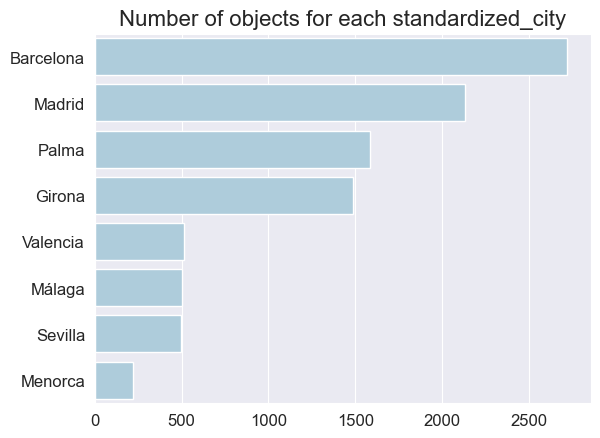

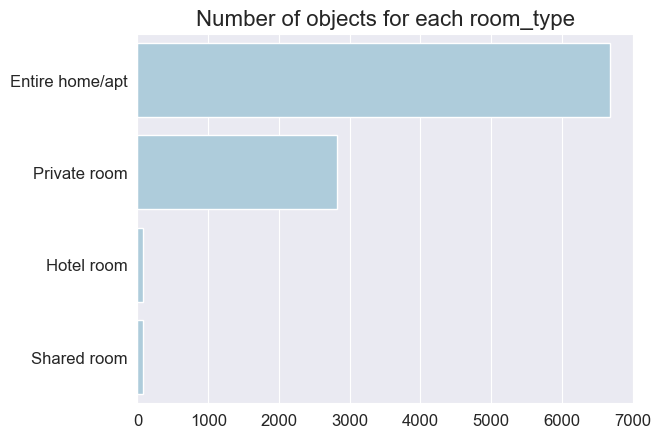

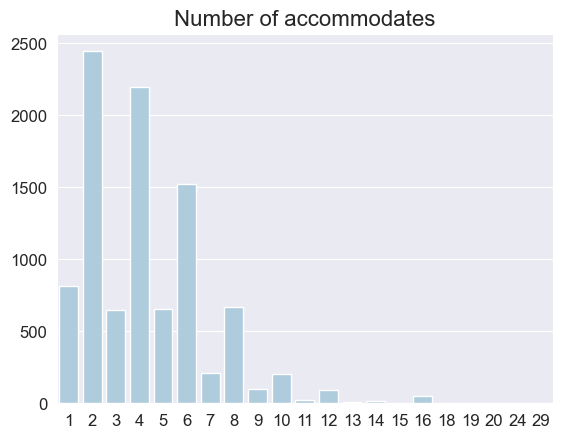

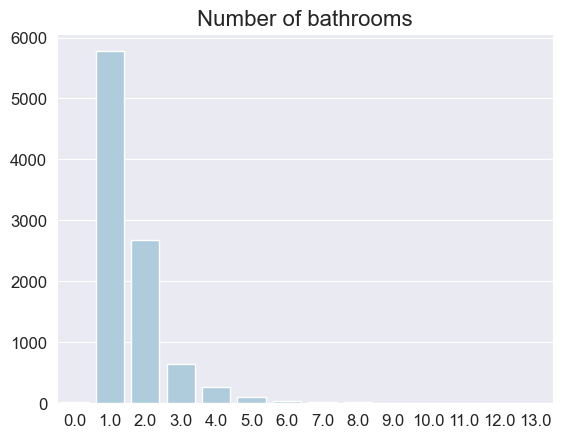

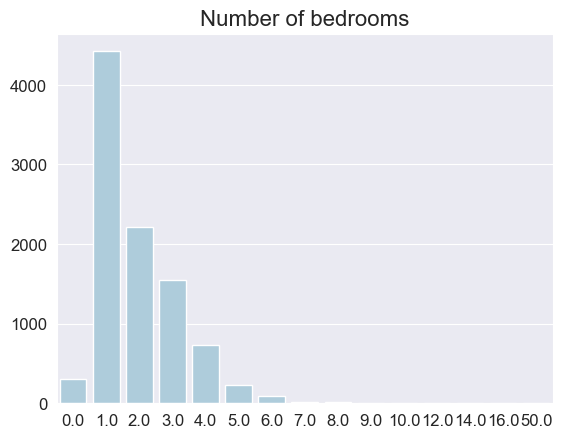

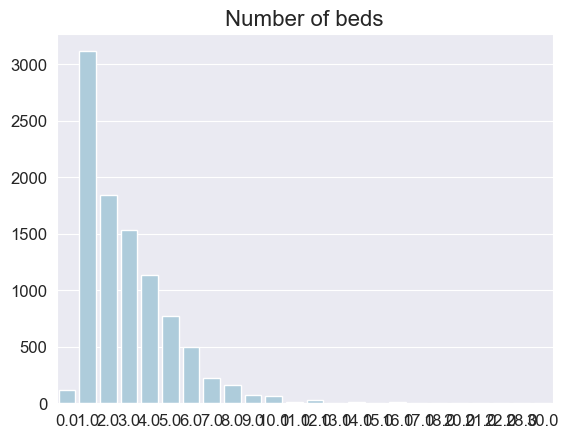

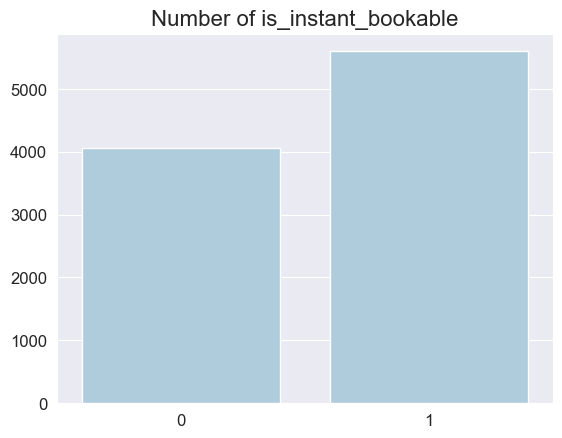

In [74]:
cat_cols = ['standardized_city', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds',
            'is_instant_bookable']
            
for col in cat_cols:
    if col == 'standardized_city' or col == 'room_type':
        sns.countplot(data=df_clean, y=col, order=df_clean[col].value_counts().index)
        plt.title(f'Number of objects for each {col}')
    else:
        sns.countplot(data=df_clean, x=col)
        plt.title(f'Number of {col}')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

Let's check extreme values.

In [75]:
df_clean[df_clean.accommodates == 29]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
3116,15883302,Ca's Misser,"Beautiful rustic farm with a total area of 21,...",102986764,Algaida,None,Entire home/apt,29,8.00,14.00,22.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",NaN,1,1125,1,5,19,27,218,3,2019-05-27,2019-09-18,800.00,80.00,90.00,90.00,60.00,90.00,70.00,1,32.00,spain,mallorca,2020-02-29,Palma,Algaida,Islas Baleares


In [76]:
df_clean[df_clean.beds == 30]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
1118,5429715,Cal Pubill de Ciuret 35pax,Cal Pubill de Ciuret �s una de les grans masie...,20320423,Vidr�,None,Entire home/apt,16,9.00,14.00,30.00,"TV, Indoor fireplace, Pool, Iron, Crib, Hair d...",NaN,2,1125,1,24,54,77,296,1,2019-12-08,2019-12-08,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,9.00,spain,girona,2020-10-28,Girona,Vidré,Cataluña


In [77]:
df_clean[df_clean.bathrooms == 12]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
1984,11196074,Finca can Domingo Es Trenc beach,"At the heart of the Balearic archipelago, sout...",16964951,Campos,None,Entire home/apt,16,12.00,10.00,16.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",NaN,3,1125,1,13,38,68,322,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,mallorca,2019-11-28,Palma,Campos,Islas Baleares
7378,30917851,CAN GRAU (CAN GRAU 24) - Villa for 24 people i...,Welcome to this impressive finca for 24 people...,80839530,Sencelles,None,Entire home/apt,24,12.00,12.00,21.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",NaN,7,1125,1,0,0,0,164,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,mallorca,2019-04-24,Palma,Sencelles,Islas Baleares
8134,34523812,NEW RESIDENCE IN MADRID 50 INDIVIDUALS ROOMS,"Full building of 52 rooms, with 10 bathrooms, ...",130100816,Pradolongo,Usera,Entire home/apt,1,12.00,50.00,1.00,"TV,Wifi,Kitchen,Elevator,Heating,Washer,Smoke ...",250.00,1,1125,1,30,60,90,365,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,madrid,2019-06-07,Madrid,Pradolongo,Comunidad de Madrid


In [78]:
df_clean[df_clean.bedrooms == 16]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
4405,19412149,"Mallaui, a whole palace by the sea","Do you want to live in a Mediterranean villa, ...",136087677,Ciutadella de Menorca,None,Entire home/apt,16,7.00,16.00,28.00,"TV,Wifi,Kitchen,Free parking on premises,Smoki...",NaN,4,30,1,9,10,10,85,4,2018-08-10,2019-07-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,18.00,spain,menorca,2020-05-31,Menorca,Ciutadella,Islas Baleares


Data with "extreme" values looks normal.

### Numerical variables

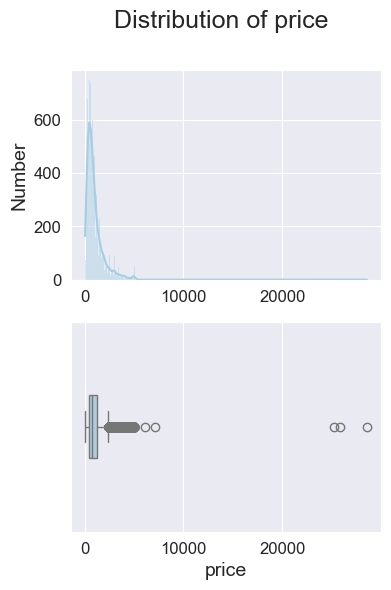

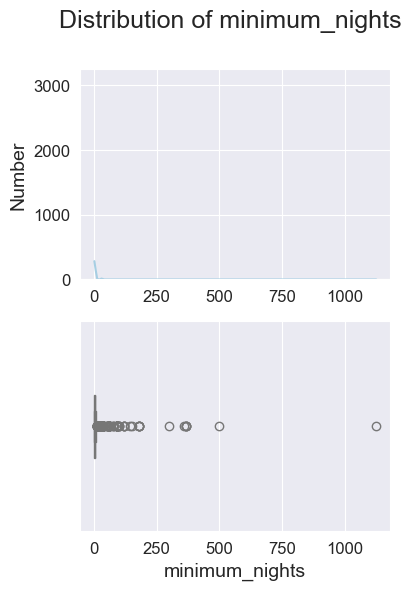

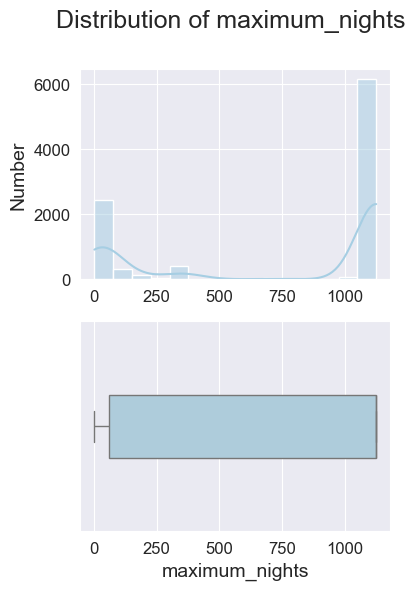

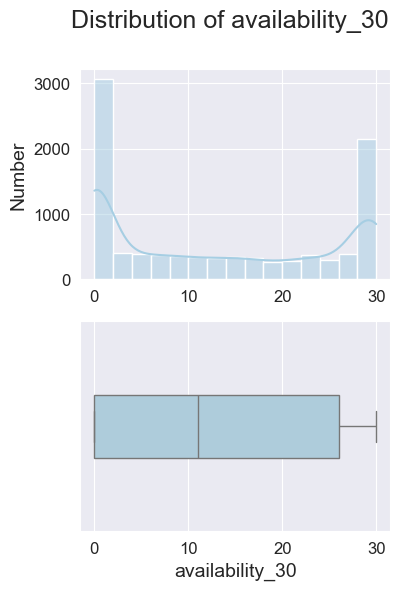

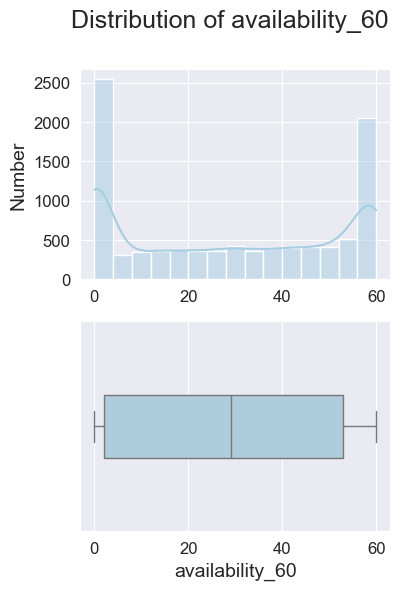

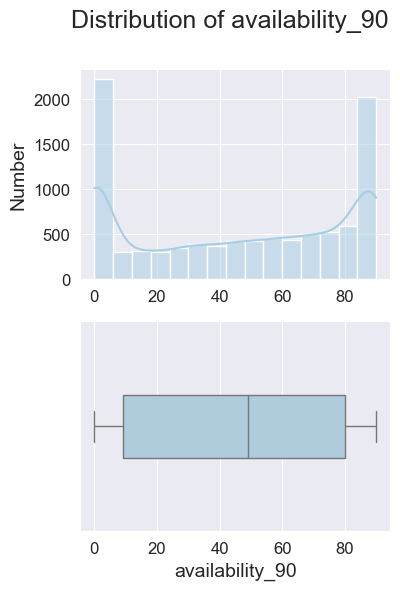

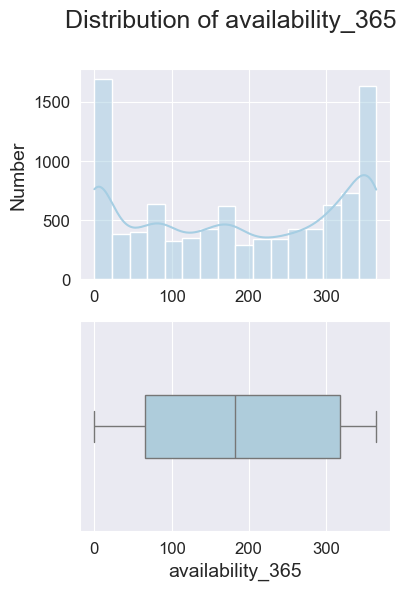

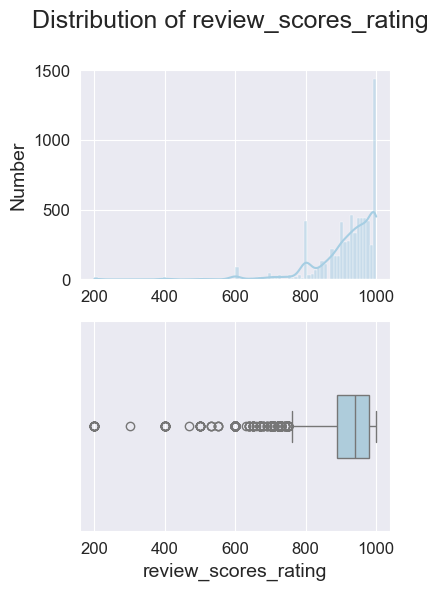

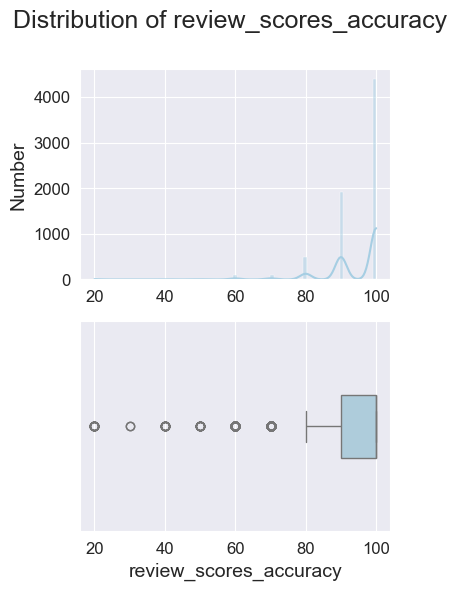

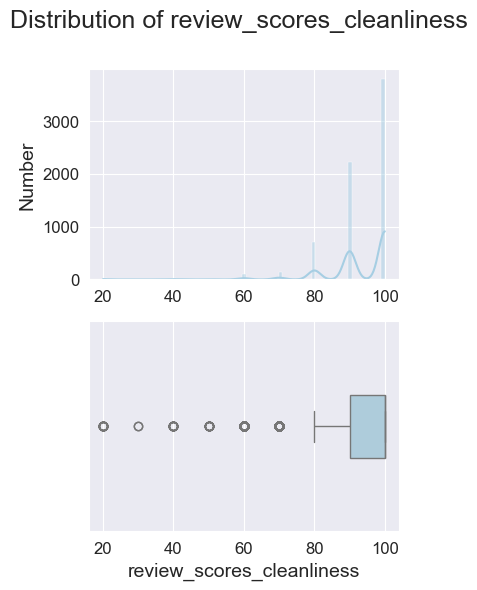

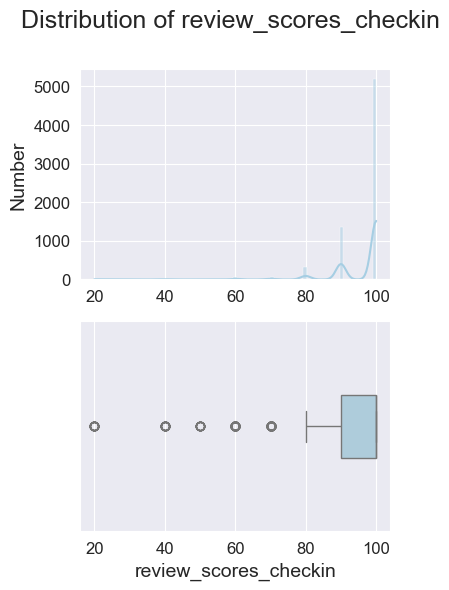

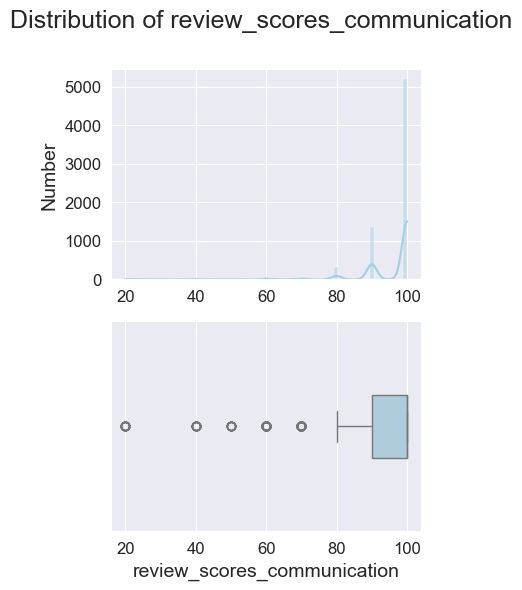

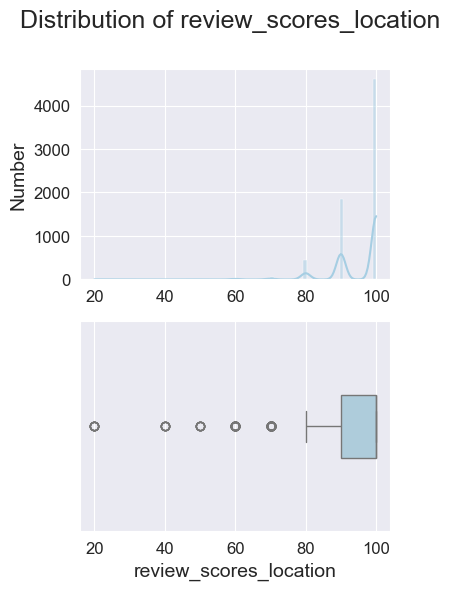

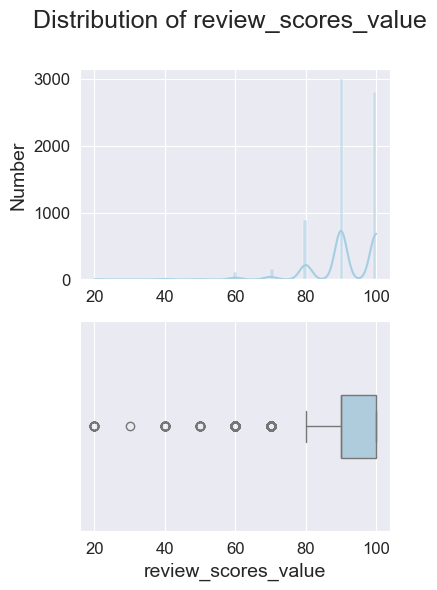

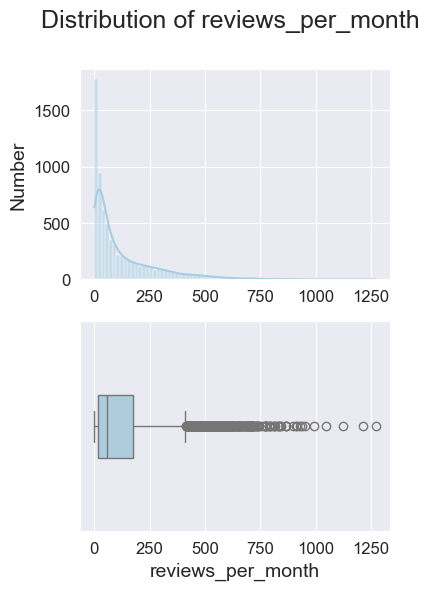

In [79]:
num_col = ['price', 'minimum_nights', 'maximum_nights',
           'availability_30', 'availability_60', 'availability_90', 'availability_365',
           'review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value', 'reviews_per_month']

for col in num_col:
    
    # visualizing the distributions
    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    fig.suptitle(f"Distribution of {col}")
    
    # histogram
    (sns.histplot(data=df_clean[col], kde=True, ax=axs[0])
        .set(xlabel=None, ylabel='Number')
    )
    
    # boxplot
    sns.boxplot(data=df_clean[col], ax=axs[1], width=0.3, orient='h')
    
    plt.show()

### Reviews

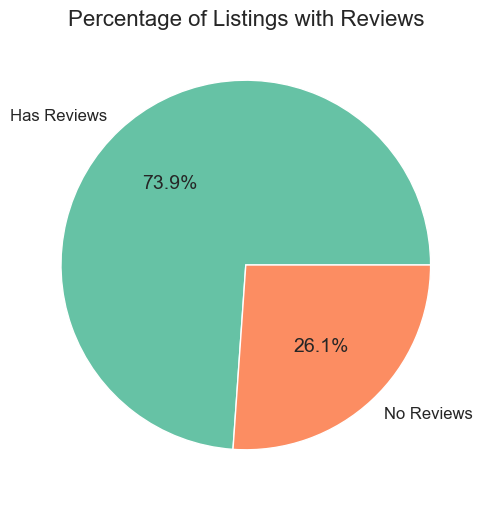

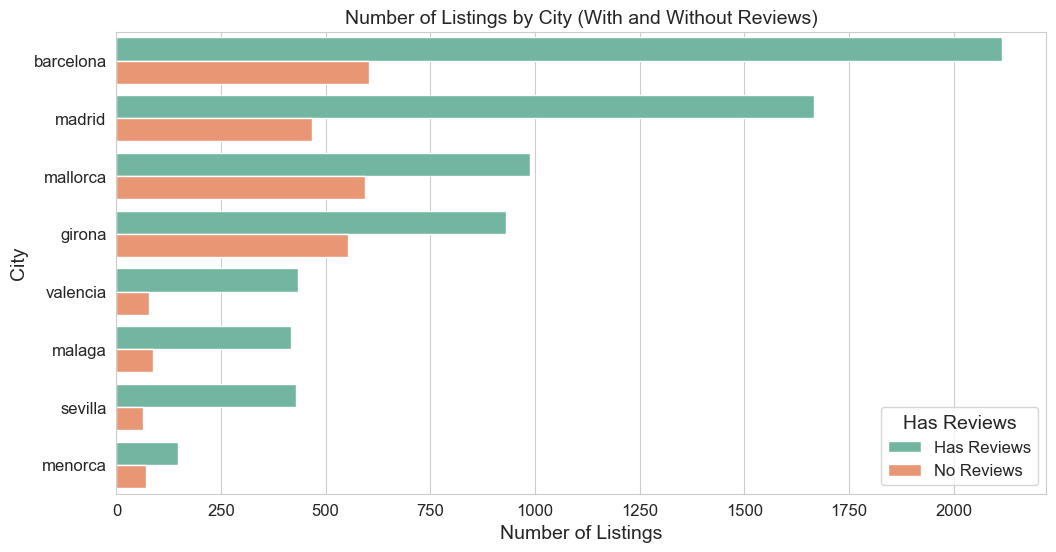

In [80]:
# Create a new column: "Has Reviews" (True/False)
df_clean['has_reviews'] = df_clean['number_of_reviews'] > 0

# Set up visualization style
#sns.set_theme(style="whitegrid")

### Listings with and without reviews
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(6, 6))
    df_clean['has_reviews'].value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                                labels=["Has Reviews", "No Reviews"], 
                                                colors=["#66c2a5", "#fc8d62"])
    plt.title("Percentage of Listings with Reviews")
    plt.ylabel("")
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=df_clean,
        y="city",
        hue="has_reviews",
        order=df_clean["city"].value_counts().index,
        hue_order=[True, False],  
        palette=["#66c2a5", "#fc8d62"] 
    )
    
    plt.title("Number of Listings by City (With and Without Reviews)", fontsize=14)
    plt.xlabel("Number of Listings")
    plt.ylabel("City")
    plt.legend(title="Has Reviews", labels=["Has Reviews", "No Reviews"]) 
    plt.show()

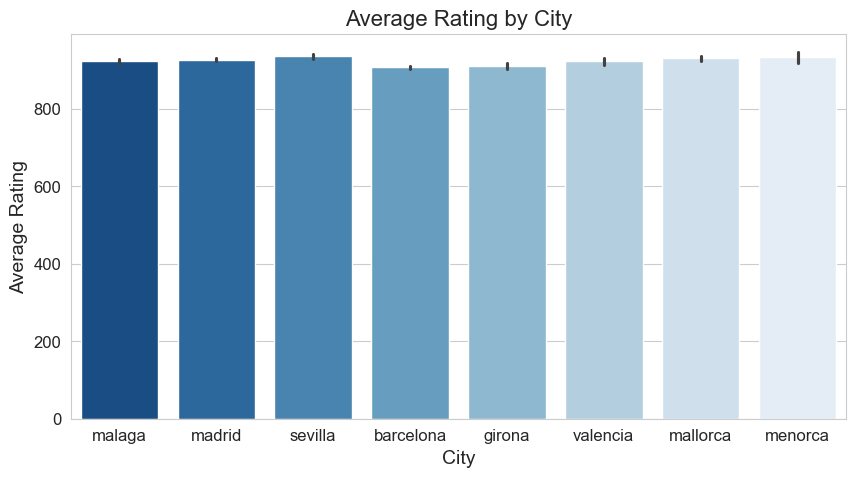

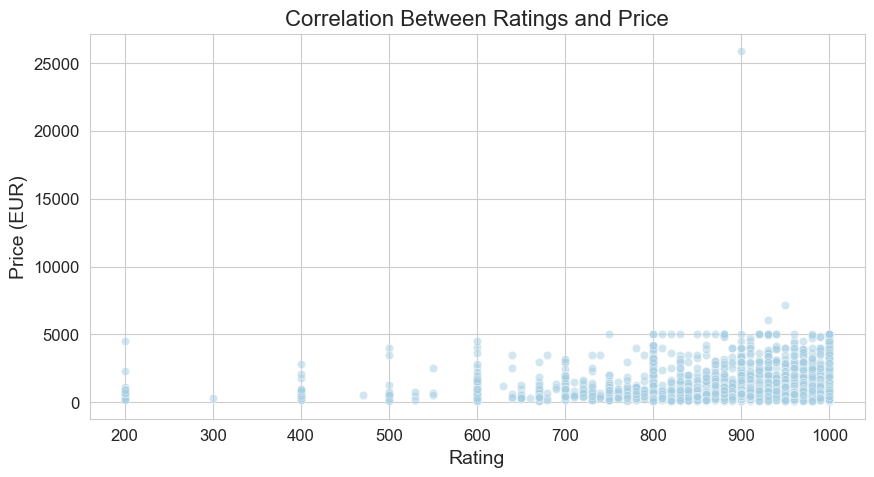

In [81]:
### Average rating by city
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='city', y='review_scores_rating', data=df_clean, 
                estimator=lambda x: x.mean(), palette="Blues_r")
    plt.title("Average Rating by City")
    plt.xlabel("City")
    plt.ylabel("Average Rating")
    plt.show()
    
    ### Correlation between ratings and price
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x='review_scores_rating', y='price', 
                    data=df_clean, alpha=0.5)
    plt.title("Correlation Between Ratings and Price")
    plt.xlabel("Rating")
    plt.ylabel("Price (EUR)")
    plt.show()

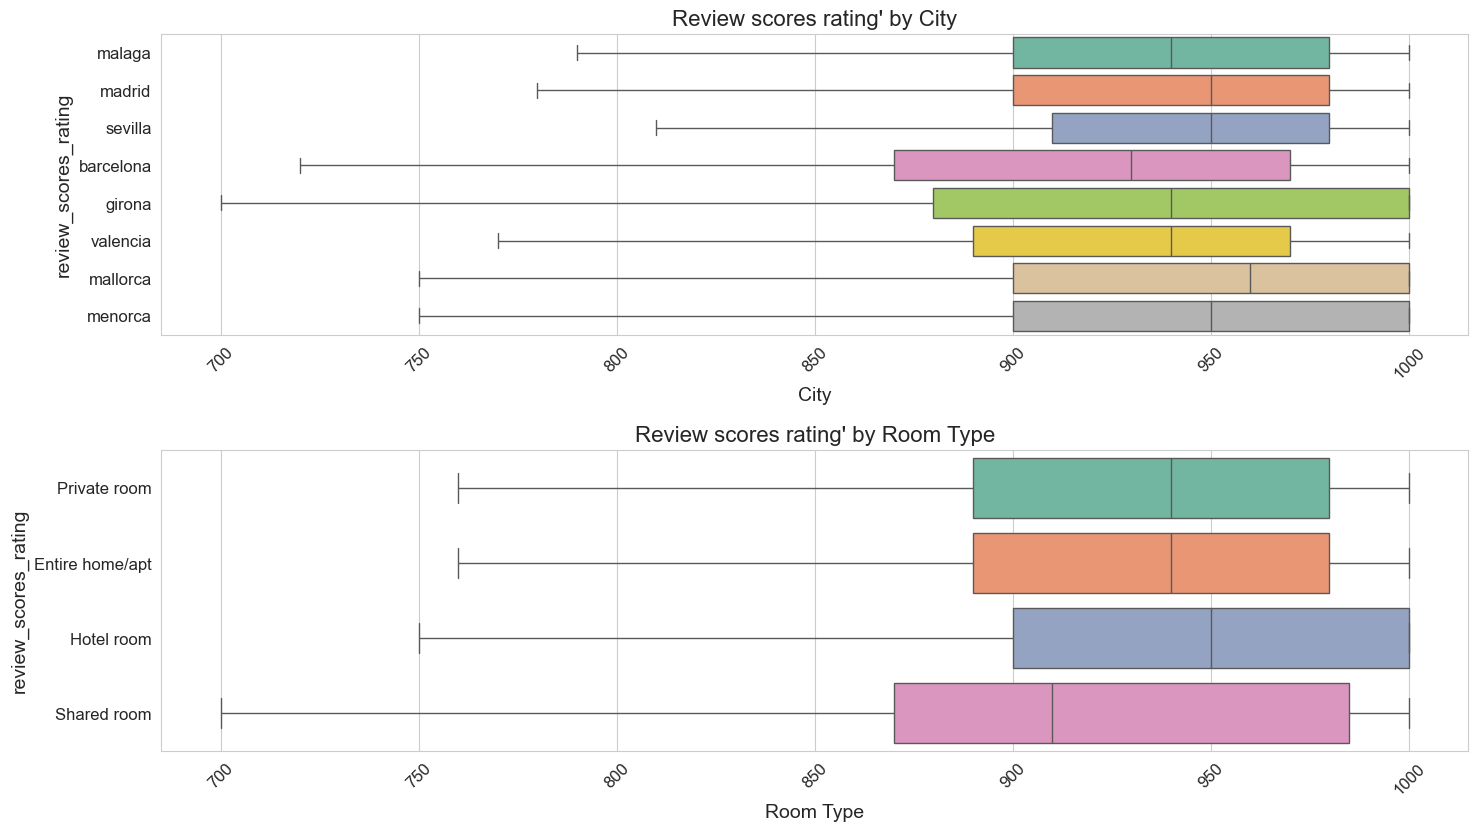

In [82]:
# Define categorical variables to analyze
categorical_vars = ["city", "room_type"]

with sns.axes_style("whitegrid"):
    # Set up the figure
    plt.figure(figsize=(15, 12))
    
    # Loop through each categorical variable and create a boxplot
    for i, category in enumerate(categorical_vars, 1):
        plt.subplot(3, 1, i)  # Create subplots (3 rows, 1 column)
        sns.boxplot(x='review_scores_rating', y=category, data=df_clean, 
                    showfliers=False, palette="Set2")
        plt.xticks(rotation=45)  # Rotate labels for readability
        plt.title(f"Review scores rating' by {category.replace('_', ' ').title()}")
        plt.xlabel(category.replace('_', ' ').title())
        plt.ylabel("review_scores_rating")
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

### Insert Date

In [83]:
df_clean.insert_date.min(), df_clean.insert_date.max()

(Timestamp('2017-01-04 00:00:00'), Timestamp('2021-02-27 00:00:00'))

Let's investigate our insert dates using `price` and `availability_30`.

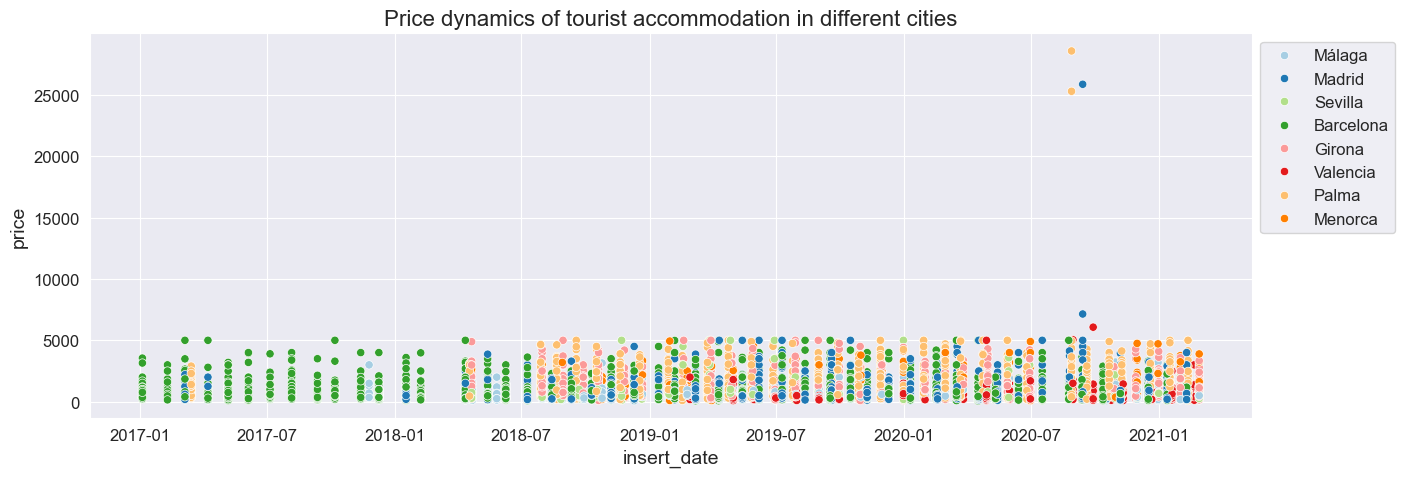

In [84]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_clean, x='insert_date', y='price', 
                hue='standardized_city')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title=None)
plt.title('Price dynamics of tourist accommodation in different cities')
plt.show()

In [85]:
df_clean.groupby(df_clean.insert_date.dt.year).price.count()

insert_date
2017     767
2018    1965
2019    3186
2020    2926
2021     565
Name: price, dtype: int64

In [86]:
df_clean.groupby(
    [df_clean.insert_date.dt.year, df_clean.insert_date.dt.month]
).availability_30.sum()

insert_date  insert_date
2017         1               773
             2               566
             3              1919
             4               957
             5               438
             6               439
             7               401
             8               403
             9               388
             10              635
             11              978
             12              715
2018         1              1467
             2               741
             4              2714
             5              1248
             6               404
             7              2510
             8              2950
             9              3143
             10             2603
             11             3771
             12             2269
2019         1              2047
             2              2876
             3              3481
             4              2722
             5              3566
             6              2293
             7    

In [87]:
df_clean.query("insert_date < last_review_date")

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community,has_reviews
1313,6547870,Bella Vista. N� de registro: HUTB005799,Bella Vista es un apartamento �nico en Barcelo...,34249903,el Baix Guinard�,Horta-Guinard�,Entire home/apt,7,1.00,3.00,4.00,"TV,Internet,Wireless Internet,Air conditioning...",750.00,4,1125,0,30,45,47,238,25,2015-10-10,2017-01-05,860.00,90.00,80.00,90.00,90.00,90.00,90.00,1,165.00,spain,barcelona,2017-01-04,Barcelona,El Baix Guinardó,Cataluña,True
3570,17398411,Newly renovated design loft CHUECA 3 IZQ,"Bright apartment in the center of Madrid, in t...",107335103,Universidad,Centro,Entire home/apt,4,1.00,1.00,2.00,"Smoke alarm, TV, Washer, Wifi, Smart lock, Iro...",490.00,15,90,1,23,50,79,79,228,2017-04-04,2020-10-18,830.00,80.00,80.00,90.00,90.00,90.00,80.00,1,526.00,spain,madrid,2020-10-17,Madrid,Universidad,Comunidad de Madrid,True
4961,21170845,DEIA famous village Font Fresca house ETV/8481,This charming 2 bedroom house in the beautiful...,24227166,Dey�,None,Entire home/apt,4,2.00,2.00,4.00,"Dishes and silverware, BBQ grill, TV, Wifi, Ir...",1030.00,4,28,1,30,60,83,131,92,2017-10-21,2020-12-20,970.00,100.00,100.00,100.00,100.00,100.00,100.00,0,237.00,spain,mallorca,2020-12-19,Palma,Deià,Islas Baleares,True


In [88]:
df.query("insert_date < first_review_date")

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date


## Conclusion
The following changes were made to the dataset:

**Duplicates**
- Removed older listings for duplicated `apartment_id`, keeping only the most recent entry (`insert_date`)

**Data Types**
- Converted the `is_instant_bookable` column to boolean: 'FALSO' → 0, 'VERDADERO' → 1
- Converted date columns to datetime format
- Converted `bathrooms` and `bedrooms` columns to numeric format

**Missing Values**
- Filled NaN values in `has_availability`: NaN → 0, 'VERDADERO' → 1
- Keep missing values in `price`

**Data Standardization**
- Added columns with city names and neighbourhood_district using correct Spanish accents
- Added a new column: `autonomous_community`

## Save Clean Dataframe

In [89]:
data_info(df_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9650 entries, 0 to 9649
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9516 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9578 non-null   float64       
 9   bedrooms                     9580 non-null   float64       
 10  beds                         9605 non-null   float64       
 11  amenities_list               9634 non-null 

apartment_id                   9650
name                           9614
description                    9459
host_id                        7268
neighbourhood_name              521
neighbourhood_district           61
room_type                         4
accommodates                     21
bathrooms                        14
bedrooms                         15
beds                             24
amenities_list                 9492
price                           418
minimum_nights                   49
maximum_nights                  147
has_availability                  2
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              2159
last_review_date               1513
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3790,39.27
review_scores_value,2640,27.36
review_scores_location,2640,27.36
review_scores_checkin,2639,27.35
review_scores_accuracy,2634,27.30
review_scores_communication,2630,27.25
review_scores_cleanliness,2628,27.23
review_scores_rating,2625,27.20
last_review_date,2523,26.15
reviews_per_month,2522,26.13



There are no full duplicates in the data



In [92]:
# save file to Data folder
df_clean.to_csv(f'../Data/{latest_table}.csv', index=False) 

## Transfer DataFrame to Stage 1 in MySQL
- first, we need install sqlalchemy
- second, connect to mysql
- third, a function to copy df to mysql table

In [ ]:
# load environment variables
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")

# environment variables because we need connect to mysql
CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('HOST'),
    'database': 'Equip_F',
    'raise_on_warnings': True
}

def df_to_mysql(df: pd.DataFrame, table_name: str):

    """
    Input: df - the DataFrame to be written to the MySQL table: pd.DataFrame; 
           table_name - the name of the table where the DataFrame will be stored: str.
    Writes a Pandas DataFrame to a MySQL table using SQLAlchemy.
    If the table already exists, it will be replaced.
    """
    
    try:
        # create a SQLAlchemy engine using environment variables
        engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{CONFIG['user']}:{CONFIG['password']}@{CONFIG['host']}/{CONFIG['database']}")

        # Use the engine with to_sql
        df.to_sql(table_name, engine, if_exists='replace', index=False)
        print("DataFrame successfully written to MySQL table OK:", table_name)

    except Exception as err:  #exception
        print(f"Error writing DataFrame to MySQL: {err}")

    finally:
        # connection is managed by SQLAlchemy engine, no need to close manually here.
        print("SQLAlchemy connection closed (managed by the engine).")

In [ ]:
# my stage1 clean table in mysql name
stage1_table_clean = "ST1_Tourist_Accommodation"

In [ ]:
df_to_mysql(df_clean, stage1_table_clean)